# Assignment 3 : Ensemble Techniques

## Pre read note

#1.Due to large volume and complexity of model evaluations and iterations , some of the models ( SVC and KNN) take long time to complete the calculation. While it has been controlled wherever possible (e.g. probability is set to False for SVC) there are still code sections where the calculation will take longer to run. (e.g. Bagging calculation based on SVC, GridsearchCV on SVC etc.)
#2.Due to performance of SVC, ROCAUC scores have not been computed for SVC as probability set to True further increases the calculation time. Also CV Score is not calculated as it takes time to calculate.
#3.Wherever possible multiprocessing using the n_jobs parameter in scikit learn library has been leveraged. However there were cases where 'out of memory'/'leak' errors were encountered ( despite running on 8 GB Macbook Air). Considering the above, a full refresh of this notebook is not recommended as this is expected to run for several minutes.
#4.Swamplots have been used with sample data drawn from the original data set(due to high volume of data)
#5.Cell numbering will be sequential for the most part, however there may be some jump in numbers due to commentary being updated. A refresh of the book ( only to set the cell sequence right) would have been avoided to save time.

## 1.Import necessary libraries

In [1]:
# suppress warnings

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# load basic libraries 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style("whitegrid")

import time

# load libraries related to model building and evaluation
 
import scipy.stats as stats
from scipy.stats import zscore
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score,RandomizedSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import chi2,RFE
from sklearn.decomposition import PCA
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression,RidgeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier,AdaBoostClassifier,BaggingClassifier
from sklearn.ensemble import VotingClassifier,ExtraTreesClassifier
from mlxtend.classifier import EnsembleVoteClassifier,StackingCVClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn import metrics



In [2]:
# creating data frame to capture comparison output of all models
modelevalcompdf = pd.DataFrame(columns=['Model','Variant','MCC','Accuracy','ROCAUC',\
                                        'CM','Precision[0]','Sensitivity',\
                                        'F1[0]','Precision[1]','Specificity','F1[1]','CV Mean-Specf.'])

# creating data frame to capture ensemble models comparison output
enmodelevalcompdf = pd.DataFrame(columns=['Method','Model','Metric','Training Score','Std Dev Training','Test Score'])


## 2. Load Data

In [3]:
# data is loaded to 2 dataframes. rawdata and mydata. 
#rawdata will represent the original data and mydata will be updated for transformations

myfile = "bank-full.csv"
rawdata = pd.read_csv(myfile) 
mydata = pd.read_csv(myfile)
rawdata.sample(10)


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,Target
20591,36,technician,single,secondary,yes,12,no,no,cellular,12,aug,587,2,-1,0,unknown,yes
6502,47,entrepreneur,married,tertiary,no,362,yes,no,unknown,27,may,97,5,-1,0,unknown,no
30554,29,housemaid,married,primary,no,132,no,no,cellular,5,feb,559,5,-1,0,unknown,no
22994,38,technician,married,secondary,no,0,no,no,cellular,26,aug,65,4,-1,0,unknown,no
1037,60,blue-collar,divorced,secondary,no,1310,no,no,unknown,7,may,152,2,-1,0,unknown,no
5532,49,blue-collar,married,primary,no,23,yes,no,unknown,23,may,247,1,-1,0,unknown,no
26236,39,services,married,secondary,no,5549,yes,no,cellular,20,nov,157,1,-1,0,unknown,no
12181,40,student,married,secondary,no,260,no,no,unknown,20,jun,197,6,-1,0,unknown,no
3381,60,retired,married,primary,no,751,yes,no,unknown,15,may,133,1,-1,0,unknown,no
26626,33,self-employed,married,tertiary,no,631,no,no,cellular,20,nov,51,2,-1,0,unknown,no


## 3. EDA, Univariate/Bivariate/Multivariate Attribute Analysis

In [4]:
#understanding column datatypes , number of columns,rows 
rawdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
age          45211 non-null int64
job          45211 non-null object
marital      45211 non-null object
education    45211 non-null object
default      45211 non-null object
balance      45211 non-null int64
housing      45211 non-null object
loan         45211 non-null object
contact      45211 non-null object
day          45211 non-null int64
month        45211 non-null object
duration     45211 non-null int64
campaign     45211 non-null int64
pdays        45211 non-null int64
previous     45211 non-null int64
poutcome     45211 non-null object
Target       45211 non-null object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [5]:
# updating the object data types as categorical 
mydata[mydata.select_dtypes(['object']).columns] = mydata.select_dtypes(['object']).apply(lambda x: x.astype('category'))

# day column also needs to be convered to categorical
mydata.day = mydata.day.astype('category')

In [6]:
#understanding column datatypes , number of columns,rows 
mydata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
age          45211 non-null int64
job          45211 non-null category
marital      45211 non-null category
education    45211 non-null category
default      45211 non-null category
balance      45211 non-null int64
housing      45211 non-null category
loan         45211 non-null category
contact      45211 non-null category
day          45211 non-null category
month        45211 non-null category
duration     45211 non-null int64
campaign     45211 non-null int64
pdays        45211 non-null int64
previous     45211 non-null int64
poutcome     45211 non-null category
Target       45211 non-null category
dtypes: category(11), int64(6)
memory usage: 2.5 MB


In [7]:
# creating function for counting outliers ( based on IQR )
def outliercount(attr,df):
    Q1 = df[attr].quantile(0.25)
    Q3 = df[attr].quantile(0.75)
    IQR = Q3-Q1
    outlier_count=((df[attr]<(Q1-(1.5*IQR))) | (df[attr]>(Q3+(1.5*IQR)))).sum()
    return outlier_count

# EDA using custom built dataframe for analyzing attributes of type integer

Item=[]
for attr in mydata.select_dtypes(include=['integer']).columns:
    Item.append([
        attr,mydata[attr].dtype,
        mydata[attr].isna().sum(),
        round((mydata[attr].isna().sum()/len(mydata[attr]))*100,2),
        mydata[attr].nunique(),
        list(mydata[attr].sample(5).drop_duplicates().values),
        mydata[attr].count(),
        len(mydata[mydata[attr]<0]),
        mydata[attr].std(),
        mydata[attr].min(),
        mydata[attr].quantile(.25),
        mydata[attr].quantile(.50),
        mydata[attr].mean(),
        mydata[attr].quantile(0.75),
        mydata[attr].max(),
        mydata[attr].skew(),
        outliercount(attr,mydata),
        round((outliercount(attr,mydata)/mydata[attr].count())*100,2)
    ]);
    
eda=pd.DataFrame(data=Item,columns=['Attribute','Datatype','Null','Null%',\
                                    'Unique','Sample','Count','-Ve Data',\
                                    'Stddev','Min','25%','50%','Mean','75%',\
                                    'Max','Skew','No.# Outlier','% Outlier'])

eda.round(2)

,Attribute,Datatype,Null,Null%,Unique,Sample,Count,-Ve Data,Stddev,Min,25%,50%,Mean,75%,Max,Skew,No.# Outlier,% Outlier
0,age,int64,0,0.0,77,"[42, 32, 31, 29, 40]",45211,0,10.62,18,33.0,39.0,40.94,48.0,95,0.68,487,1.08
1,balance,int64,0,0.0,7168,"[150, 2626, 24, 1313, 1137]",45211,3766,3044.77,-8019,72.0,448.0,1362.27,1428.0,102127,8.36,4729,10.46
2,duration,int64,0,0.0,1573,"[148, 151, 145, 27, 122]",45211,0,257.53,0,103.0,180.0,258.16,319.0,4918,3.14,3235,7.16
3,campaign,int64,0,0.0,48,"[5, 4, 2, 1]",45211,0,3.10,1,1.0,2.0,2.76,3.0,63,4.90,3064,6.78
4,pdays,int64,0,0.0,559,"[151, -1]",45211,36954,100.13,-1,-1.0,-1.0,40.20,-1.0,871,2.62,8257,18.26
5,previous,int64,0,0.0,41,[0],45211,0,2.30,0,0.0,0.0,0.58,0.0,275,41.85,8257,18.26


#### Based on the above we can infer the following:

#1.There is no missing data.
#2.Most of the attributes have skeweness.
#3.There are outliers in most of the attribues. Age attribute has least number of outliers, while pdays and previous have largest number of outliers. These outliers need to be reviewed to decide how to handle the same.
#4.There are negative values in balance attribute and pdays attribute. The validity of the data needs to be reviewed.

In [8]:
# EDA for attributes of type category

mydata.select_dtypes(include=['category']).describe(include='all')

,job,marital,education,default,housing,loan,contact,day,month,poutcome,Target
count,45211,45211,45211,45211,45211,45211,45211,45211,45211,45211,45211
unique,12,3,4,2,2,2,3,31,12,4,2
top,blue-collar,married,secondary,no,yes,no,cellular,20,may,unknown,no
freq,9732,27214,23202,44396,25130,37967,29285,2752,13766,36959,39922


#### Based on the above we can infer the following:

#1.There is no missing data.
#2.Cateogries need to be converted to numeric for model builing

Skewness of age distribution = 0.68


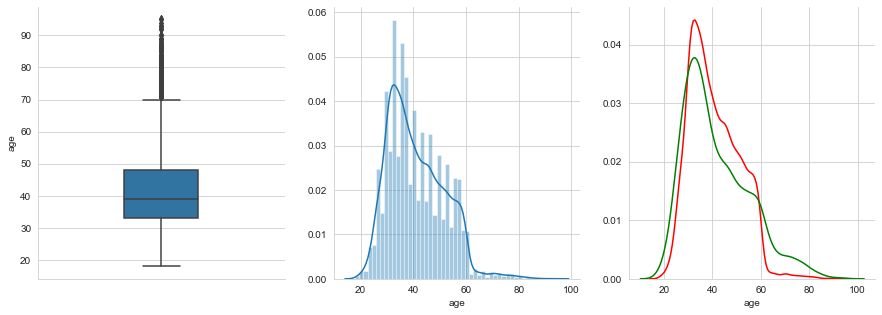

In [9]:
# Analysis of Attribute: Age
curattr = 'age'
f,axes = plt.subplots(1,3)
sns.boxplot(x = mydata[curattr],orient = 'v',data = mydata,width=.3, ax = axes[0])
sns.distplot( mydata[curattr],ax = axes[1])
sns.distplot( mydata[mydata['Target'] == 'no'][curattr],hist = False,color = 'r',ax = axes[2])
sns.distplot( mydata[mydata['Target'] == 'yes'][curattr],hist = False,color = 'g',ax = axes[2])
sns.despine()
plt.gcf().set_size_inches(15, 5)
curattr_skew = mydata[curattr].skew()
print('Skewness of ' + curattr +' distribution = %1.2f' %(curattr_skew) )

#### Based on the above we can infer the following

#1.There are outliers in data
#2.Mean and Median are not very close.Data seems to be fairly normally distributed, though not fully normally distributed. Multiple gaussians noted.
#3.There is highly significant overlap of classes for customers who have subscribed bank term deposit and those who have not ,across age. Among the youngest and olderst the proportion of customers subscribing to bank term deposit seems to be higher than those who do not. Among the rest of the customers in middle age, proportion of customers not subscribing to bank term deposit seems to be more than those who subscribe to bank term deposit.
#4.We can apply binning to bucket the age in to various groups, for analysis purpose.

In [10]:
# for analysis purpose we are bucketing age under various group 

mydata['age_range'] = pd.cut(x=mydata['age'], bins=[10,20, 29, 39, 49,59,100],\
                             labels=['< 19','20-29', '30-39', '40-49','50-59','> 60'])

Values,Count,Mix%,Target-No %,Target-Yes%
30-39,18089,40.01,89.42,10.58
40-49,11655,25.78,90.88,9.12
50-59,8410,18.6,90.67,9.33
20-29,5176,11.45,82.71,17.29
> 60,1784,3.95,66.37,33.63
< 19,97,0.21,65.98,34.02


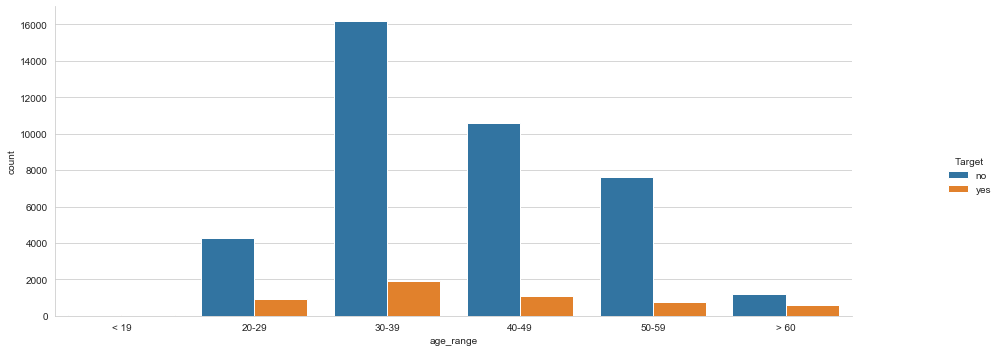

In [11]:
# Analysis of Attribute: age_range
curattr = 'age_range'
sns.catplot(x=curattr, hue="Target", kind="count",data=mydata);
sns.despine()
plt.gcf().set_size_inches(15, 5)
Item=[]
for val in mydata[curattr].unique():
    Item.append([
        val,
        len(mydata[mydata[curattr] == val]),
        round((len(mydata[mydata[curattr] == val])/len(mydata[curattr]))*100,2),
        round(((len(mydata[(mydata[curattr] == val) & (mydata['Target'] == 'no')]))\
              /(len(mydata[(mydata[curattr] == val) ])))*100,2),
        round(((len(mydata[(mydata[curattr] == val) & (mydata['Target'] == 'yes')]))\
              /(len(mydata[(mydata[curattr] == val) ])))*100,2)
        
    ]);
    
curattrdf=pd.DataFrame(data=Item,columns=['Values','Count','Mix%','Target-No %','Target-Yes%'])
curattrdf.round(2).sort_values('Count',ascending=False).style.hide_index()\
                                                   .highlight_max(subset=['Count','Mix%','Target-Yes%']) 

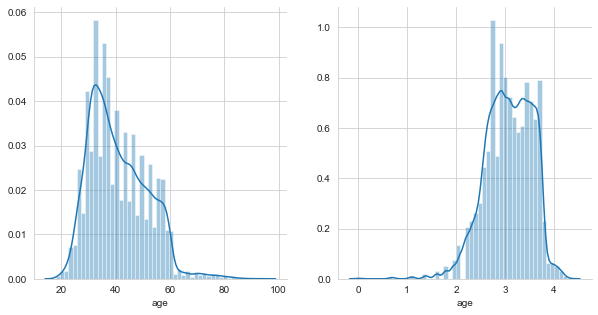

In [12]:
# we will apply log transformation on 'age' attribute to handle outliers.
attr='age'
logage=np.log(mydata[attr]-(mydata[attr].min()-1))

fig,ax =plt.subplots(1,2)
ax1,ax2=ax.flatten()
sns.distplot(mydata[attr],ax=ax1,label='original distribution')
sns.distplot(logage,ax=ax2,label='log transformed')
sns.despine()
plt.gcf().set_size_inches(10, 5)

In [13]:
#update dataframe with log transformed data for attribute = 'age'
mydata['age_log']=logage
mydata.sample(5)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,Target,age_range,age_log
42006,38,housemaid,divorced,secondary,no,70,no,no,cellular,27,oct,255,3,148,1,success,yes,30-39,3.044522
14080,41,technician,married,secondary,no,-172,yes,yes,cellular,11,jul,132,2,-1,0,unknown,no,40-49,3.178054
14052,27,admin.,married,secondary,no,941,yes,no,cellular,11,jul,124,1,-1,0,unknown,no,20-29,2.302585
39038,27,management,single,tertiary,no,2802,yes,no,cellular,18,may,84,1,-1,0,unknown,no,20-29,2.302585
27821,31,management,single,tertiary,no,581,yes,yes,cellular,28,jan,572,1,-1,0,unknown,no,30-39,2.639057


Skewness of balance distribution = 8.36


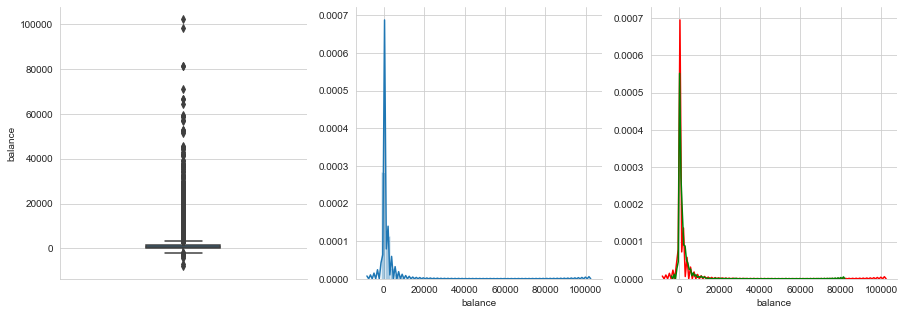

In [14]:
# Analysis of attribute: balance

curattr = 'balance'
f,axes = plt.subplots(1,3)
sns.boxplot(x = mydata[curattr],orient = 'v',data = mydata,width=.3, ax = axes[0])
sns.distplot( mydata[curattr],ax = axes[1])
sns.distplot( mydata[mydata['Target'] == 'no'][curattr],hist = False,color = 'r',ax = axes[2])
sns.distplot( mydata[mydata['Target'] == 'yes'][curattr],hist = False,color = 'g',ax = axes[2])
sns.despine()
plt.gcf().set_size_inches(15, 5)
curattr_skew = mydata[curattr].skew()
print('Skewness of ' + curattr +' distribution = %1.2f' %(curattr_skew) )

#### Based on the above we can infer the following

#1.Distribution is heavily skewed and there are many outliers.
#2.We can bin the balance variable to groups


In [15]:
# if the balance is negative check if any customer subscribes to bank term deposit
mydata[mydata.balance<0].Target.value_counts()

no     3556
yes     210
Name: Target, dtype: int64

In [16]:
mydata['bal_range'] = pd.cut(x=mydata['balance'], bins=[-10000,-1,99,499, 999, 1499, 1999,9999,10000000],\
                             labels=['< 0','0-99', '100-499', '500-999','1000-1499','1500-1999','2000-9999','>= 10000'])

Values,Count,Mix%,Target-No %,Target-Yes%
100-499,11200,24.77,88.67,11.33
0-99,8671,19.18,91.89,8.11
2000-9999,7677,16.98,83.4,16.6
500-999,6932,15.33,87.68,12.32
< 0,3766,8.33,94.42,5.58
1000-1499,3741,8.27,87.3,12.7
1500-1999,2395,5.3,84.59,15.41
>= 10000,829,1.83,83.72,16.28


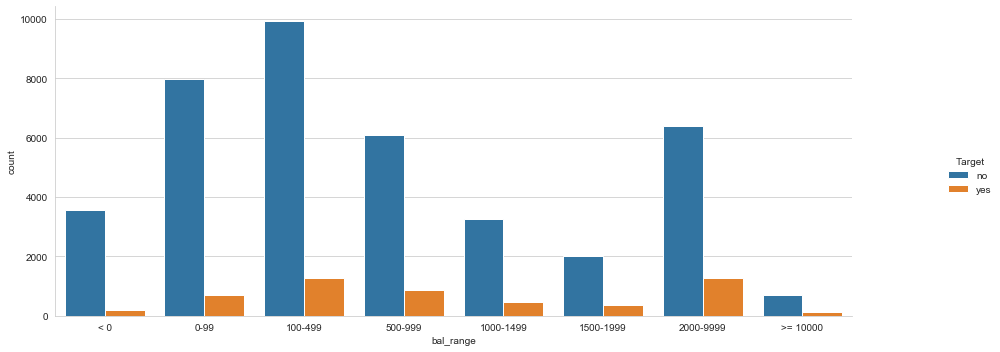

In [17]:
# Analysis of Attribute: bal_range
curattr = 'bal_range'
sns.catplot(x=curattr, hue="Target", kind="count",data=mydata);
sns.despine()
plt.gcf().set_size_inches(15, 5)
Item=[]
for val in mydata[curattr].unique():
    Item.append([
        val,
        len(mydata[mydata[curattr] == val]),
        round((len(mydata[mydata[curattr] == val])/len(mydata[curattr]))*100,2),
        round(((len(mydata[(mydata[curattr] == val) & (mydata['Target'] == 'no')]))\
              /(len(mydata[(mydata[curattr] == val) ])))*100,2),
        round(((len(mydata[(mydata[curattr] == val) & (mydata['Target'] == 'yes')]))\
              /(len(mydata[(mydata[curattr] == val) ])))*100,2)
        
    ]);
    
curattrdf=pd.DataFrame(data=Item,columns=['Values','Count','Mix%','Target-No %','Target-Yes%'])
curattrdf.round(2).sort_values('Count',ascending=False).style.hide_index()\
                                                   .highlight_max(subset=['Count','Mix%','Target-Yes%']) 

### Based on the above we can infer the following:

#1.Balance attribute has been grouped based on balance range buckets.
#2.Most of the customers have balance in the range 100-499
#3.However conversion ratio is highest in balance range 2000 to 9999.
#4.Since the data has outliers, we will use the balance range for model building purpose.

Skewness of duration distribution = 3.14


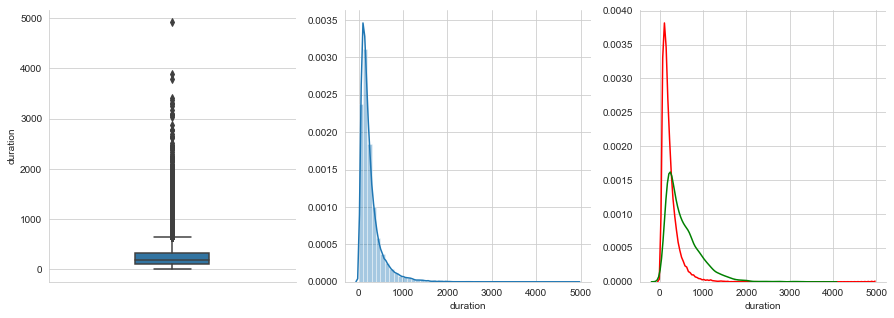

In [18]:
# Analysis of Attribute: duration
curattr = 'duration'
f,axes = plt.subplots(1,3)
sns.boxplot(x = mydata[curattr],orient = 'v',data = mydata,width=.3, ax = axes[0])
sns.distplot( mydata[curattr],ax = axes[1])
sns.distplot( mydata[mydata['Target'] == 'no'][curattr],hist = False,color = 'r',ax = axes[2])
sns.distplot( mydata[mydata['Target'] == 'yes'][curattr],hist = False,color = 'g',ax = axes[2])
sns.despine()
plt.gcf().set_size_inches(15, 5)
curattr_skew = mydata[curattr].skew()
print('Skewness of ' + curattr +' distribution = %1.2f' %(curattr_skew) )

#### Based on the above we can infer the following:

#1.There is no missing data.
#2.Data is highly sckewed. However this attribute cannot be used for model building as value for this  attribute cannot be an input to the model ( as the value can be determined only after the call takes place)
#3.Nevertheless, we can group the variables to check if there is any inference possible out of this attribute

In [19]:
mydata['dur_range'] = pd.cut(x=mydata['duration'], bins=[-1,300, 420, 600,9999],\
                             labels=['<= 5min', '5-7min', '7-10min','>10min'])

Values,Count,Mix%,Target-No %,Target-Yes%
<= 5min,32937,72.85,94.44,5.56
5-7min,5034,11.13,84.31,15.69
>10min,3790,8.38,51.64,48.36
7-10min,3450,7.63,75.8,24.2


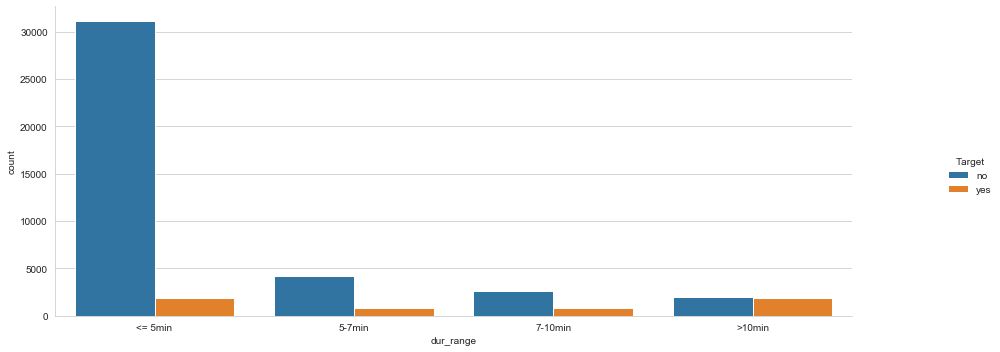

In [20]:
# Analysis of Attribute: dur_range
curattr = 'dur_range'
sns.catplot(x=curattr, hue="Target", kind="count",data=mydata);
sns.despine()
plt.gcf().set_size_inches(15, 5)
Item=[]
for val in mydata[curattr].unique():
    Item.append([
        val,
        len(mydata[mydata[curattr] == val]),
        round((len(mydata[mydata[curattr] == val])/len(mydata[curattr]))*100,2),
        round(((len(mydata[(mydata[curattr] == val) & (mydata['Target'] == 'no')]))\
              /(len(mydata[(mydata[curattr] == val) ])))*100,2),
        round(((len(mydata[(mydata[curattr] == val) & (mydata['Target'] == 'yes')]))\
              /(len(mydata[(mydata[curattr] == val) ])))*100,2)
        
    ]);
    
curattrdf=pd.DataFrame(data=Item,columns=['Values','Count','Mix%','Target-No %','Target-Yes%'])
curattrdf.round(2).sort_values('Count',ascending=False).style.hide_index()\
                                                   .highlight_max(subset=['Count','Mix%','Target-Yes%']) 

#### Based on the above we can infer the following:
#1.Conversion ratio is highest (close to 50%) if the duration of the contact is more than 10 min.
#2.Customers are mostly contacted for less than 5 min where the conversion ratio is the lowest

Skewness of campaign distribution = 4.90


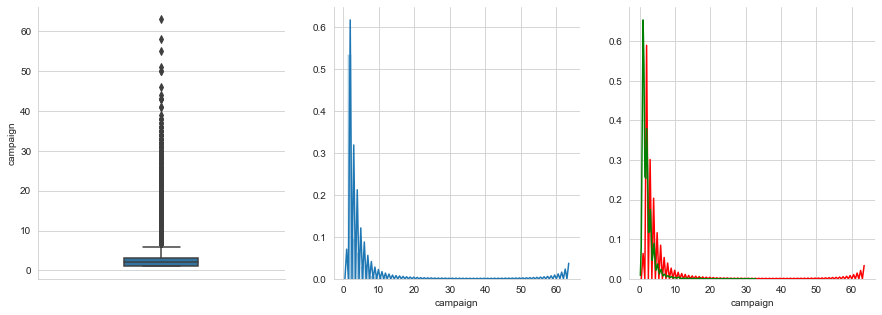

In [21]:
# Analysis of Attribute: campaign
curattr = 'campaign'
f,axes = plt.subplots(1,3)
sns.boxplot(x = mydata[curattr],orient = 'v',data = mydata,width=.3, ax = axes[0])
sns.distplot( mydata[curattr],ax = axes[1])
sns.distplot( mydata[mydata['Target'] == 'no'][curattr],hist = False,color = 'r',ax = axes[2])
sns.distplot( mydata[mydata['Target'] == 'yes'][curattr],hist = False,color = 'g',ax = axes[2])
sns.despine()
plt.gcf().set_size_inches(15, 5)
curattr_skew = mydata[curattr].skew()
print('Skewness of ' + curattr +' distribution = %1.2f' %(curattr_skew) )

#### Based on the above we can infer the following:

#1.There is no missing data.
#2.Data is heavily skewed.
#3.We will apply binning to group the data.

In [22]:
mydata['camp_range'] = pd.cut(x=mydata['campaign'], bins=[0,1,2,3, 5,10,100],\
                             labels=['1', '2','3', '4-5','6-10','>10'])

Values,Count,Mix%,Target-No %,Target-Yes%
1,17544,38.8,85.4,14.6
2,12505,27.66,88.8,11.2
3,5521,12.21,88.81,11.19
4-5,5286,11.69,91.37,8.63
6-10,3159,6.99,93.48,6.52
>10,1196,2.65,96.07,3.93


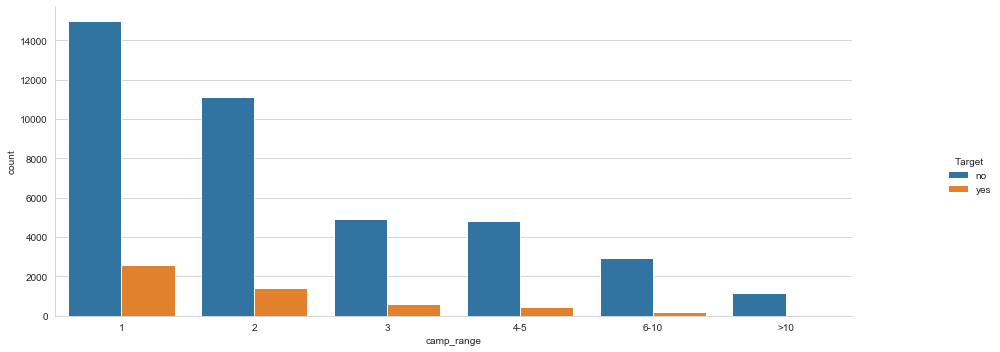

In [23]:
# Analysis of Attribute: camp_range
curattr = 'camp_range'
sns.catplot(x=curattr, hue="Target", kind="count",data=mydata);
sns.despine()
plt.gcf().set_size_inches(15, 5)
Item=[]
for val in mydata[curattr].unique():
    Item.append([
        val,
        len(mydata[mydata[curattr] == val]),
        round((len(mydata[mydata[curattr] == val])/len(mydata[curattr]))*100,2),
        round(((len(mydata[(mydata[curattr] == val) & (mydata['Target'] == 'no')]))\
              /(len(mydata[(mydata[curattr] == val) ])))*100,2),
        round(((len(mydata[(mydata[curattr] == val) & (mydata['Target'] == 'yes')]))\
              /(len(mydata[(mydata[curattr] == val) ])))*100,2)
        
    ]);
    
curattrdf=pd.DataFrame(data=Item,columns=['Values','Count','Mix%','Target-No %','Target-Yes%'])
curattrdf.round(2).sort_values('Count',ascending=False).style.hide_index()\
                                                   .highlight_max(subset=['Count','Mix%','Target-Yes%']) 

#### Based on the above we can infer the following:

#1.Conversion ratio is highest during the 1st contact in campaign.
#2.As the number of contact increases, the conversion ratio decreases.

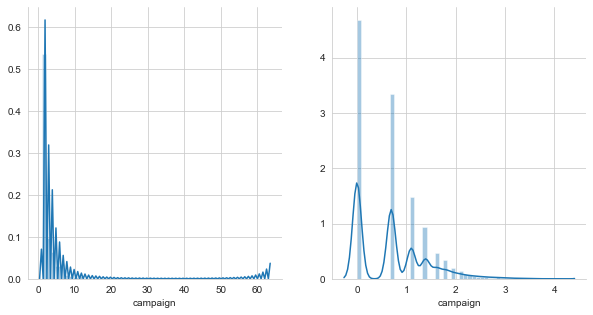

In [24]:
# we will apply log transformation to age attribute to handle outliers.
attr='campaign'
logcamp=np.log(mydata[attr]-(mydata[attr].min()-1))

fig,ax =plt.subplots(1,2)
ax1,ax2=ax.flatten()
sns.distplot(mydata[attr],ax=ax1,label='original distribution')
sns.distplot(logcamp,ax=ax2,label='log transformed')
sns.despine()
plt.gcf().set_size_inches(10, 5)

In [25]:
#update dataframe with log transformed data for attribute = 'campaign'
mydata['campaign_log']=logcamp
mydata.sample(5)

,age,job,marital,education,default,balance,housing,loan,contact,day,...,pdays,previous,poutcome,Target,age_range,age_log,bal_range,dur_range,camp_range,campaign_log
41320,62,unemployed,married,secondary,no,780,no,no,cellular,28,...,-1,0,unknown,yes,> 60,3.806662,500-999,<= 5min,2,0.693147
10579,53,housemaid,married,secondary,no,2406,yes,no,unknown,16,...,-1,0,unknown,no,50-59,3.583519,2000-9999,5-7min,2,0.693147
35789,46,blue-collar,single,secondary,no,-100,yes,no,cellular,8,...,303,1,failure,no,40-49,3.367296,< 0,7-10min,2,0.693147
9687,42,blue-collar,married,primary,no,480,yes,no,unknown,6,...,-1,0,unknown,no,40-49,3.218876,100-499,<= 5min,>10,2.484907
3593,53,admin.,married,secondary,no,1739,yes,no,unknown,15,...,-1,0,unknown,no,50-59,3.583519,1500-1999,<= 5min,3,1.098612


Skewness of pdays distribution = 2.62


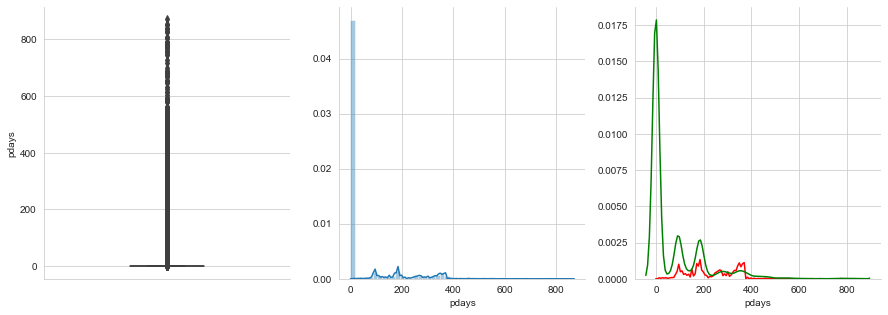

In [26]:
# Analysis of Attribute: pdays
curattr = 'pdays'
f,axes = plt.subplots(1,3)
sns.boxplot(x = mydata[curattr],orient = 'v',data = mydata,width=.3, ax = axes[0])
sns.distplot( mydata[curattr],ax = axes[1])
sns.distplot( mydata[mydata['Target'] == 'no'][curattr],hist = False,color = 'r',ax = axes[2])
sns.distplot( mydata[mydata['Target'] == 'yes'][curattr],hist = False,color = 'g',ax = axes[2])
sns.despine()
plt.gcf().set_size_inches(15, 5)
curattr_skew = mydata[curattr].skew()
print('Skewness of ' + curattr +' distribution = %1.2f' %(curattr_skew) )

#### Based on the above we can infer the following:

#1.There is no missing data.
#2.There are negative values. It can be possible data quality issue and one assumption can be to consider the absolute value for this (i.e -1 converted to 1)
#3.Data is heavily skewed. we can apply binning for this.

In [27]:
mydata['pdays']= abs(mydata['pdays'])

In [28]:
mydata['pdays_range'] = pd.cut(x=mydata['pdays'], bins=[0,7,31,91,180,366,1000],\
                             labels=['Up to 7','8-31', '32-91','92-180','181-366','> 366'])

Values,Count,Mix%,Target-No %,Target-Yes%
Up to 7,37037,81.92,90.84,9.16
181-366,4446,9.83,82.23,17.77
92-180,2354,5.21,74.3,25.7
32-91,651,1.44,54.38,45.62
> 366,613,1.36,69.98,30.02
8-31,110,0.24,82.73,17.27


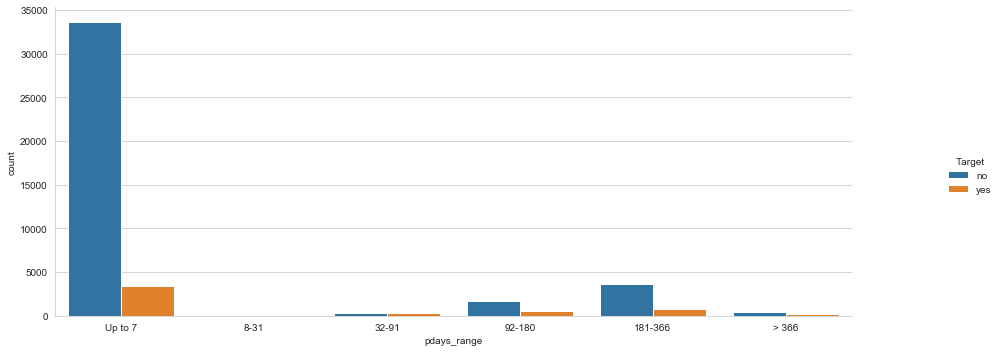

In [29]:
# Analysis of Attribute: pdays_range
curattr = 'pdays_range'
sns.catplot(x=curattr, hue="Target", kind="count",data=mydata);
sns.despine()
plt.gcf().set_size_inches(15, 5)
Item=[]
for val in mydata[curattr].unique():
    Item.append([
        val,
        len(mydata[mydata[curattr] == val]),
        round((len(mydata[mydata[curattr] == val])/len(mydata[curattr]))*100,2),
        round(((len(mydata[(mydata[curattr] == val) & (mydata['Target'] == 'no')]))\
              /(len(mydata[(mydata[curattr] == val) ])))*100,2),
        round(((len(mydata[(mydata[curattr] == val) & (mydata['Target'] == 'yes')]))\
              /(len(mydata[(mydata[curattr] == val) ])))*100,2)
        
    ]);
    
curattrdf=pd.DataFrame(data=Item,columns=['Values','Count','Mix%','Target-No %','Target-Yes%'])
curattrdf.round(2).sort_values('Count',ascending=False).style.hide_index()\
                                                   .highlight_max(subset=['Count','Mix%','Target-Yes%']) 

#### Based on the above we can infer the following:

#1.Most of customer seems to have been contacted within a 7 days of previous marketing campaign.Hence the conversion ratio is lowest.
#2.Conversion ratio is highest when the customers are contacted between 32 to 91 days of previous marketing campaign.

In [30]:
# we will apply log transformation to age attribute to handle outliers.
attr='pdays'
logpdays=np.log1p(np.log(mydata[attr]-(mydata[attr].min()-1)))

#update dataframe with log transformed data for attribute = 'campaign'
mydata['pdays_log']=logpdays
mydata.sample(5)

,age,job,marital,education,default,balance,housing,loan,contact,day,...,poutcome,Target,age_range,age_log,bal_range,dur_range,camp_range,campaign_log,pdays_range,pdays_log
16778,33,admin.,married,tertiary,no,640,no,no,cellular,24,...,unknown,no,30-39,2.772589,500-999,5-7min,1,0.000000,Up to 7,0.000000
14499,55,blue-collar,married,primary,no,284,no,yes,telephone,14,...,unknown,no,50-59,3.637586,100-499,<= 5min,4-5,1.386294,Up to 7,0.000000
45177,36,admin.,divorced,secondary,no,1224,yes,no,cellular,12,...,success,yes,30-39,2.944439,1000-1499,7-10min,1,0.000000,> 366,1.935031
17509,37,services,married,secondary,no,3,yes,no,cellular,29,...,unknown,no,30-39,2.995732,0-99,<= 5min,6-10,1.791759,Up to 7,0.000000
7259,23,technician,married,secondary,no,8254,yes,no,unknown,29,...,unknown,no,20-29,1.791759,2000-9999,5-7min,3,1.098612,Up to 7,0.000000


Skewness of previous distribution = 41.85


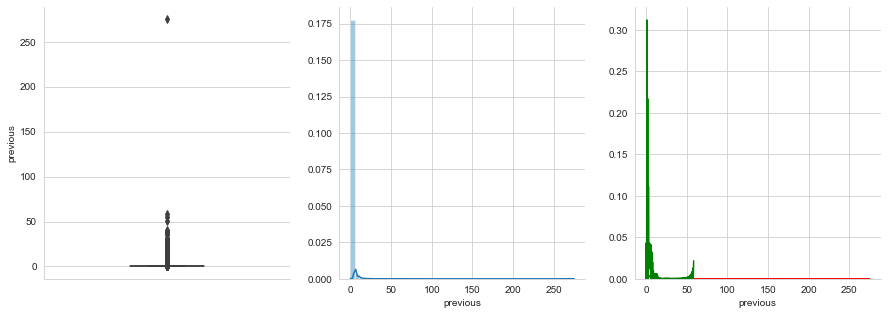

In [31]:
# Analysis of Attribute: previous
curattr = 'previous'
f,axes = plt.subplots(1,3)
sns.boxplot(x = mydata[curattr],orient = 'v',data = mydata,width=.3, ax = axes[0])
sns.distplot( mydata[curattr],ax = axes[1])
sns.distplot( mydata[mydata['Target'] == 'no'][curattr],hist = False,color = 'r',ax = axes[2])
sns.distplot( mydata[mydata['Target'] == 'yes'][curattr],hist = False,color = 'g',ax = axes[2])
sns.despine()
plt.gcf().set_size_inches(15, 5)
curattr_skew = mydata[curattr].skew()
print('Skewness of ' + curattr +' distribution = %1.2f' %(curattr_skew) )

#### Based on the above we can infer the following:

#1.There is no missing data.
#2.There are several outliers.
#3.Data is heavily skewed. We will apply binning.

In [32]:
mydata['prev_range'] = pd.cut(x=mydata['previous'], bins=[-1,0,1,2,3,4,5,10,1000],\
                             labels=['No Contact','1','2','3','4','5','6-10','> 10'])

Values,Count,Mix%,Target-No %,Target-Yes%
No Contact,36954,81.74,90.84,9.16
1,2772,6.13,78.97,21.03
2,2106,4.66,78.35,21.65
3,1142,2.53,74.26,25.74
6-10,770,1.7,70.65,29.35
4,714,1.58,76.05,23.95
5,459,1.02,73.64,26.36
> 10,294,0.65,81.63,18.37


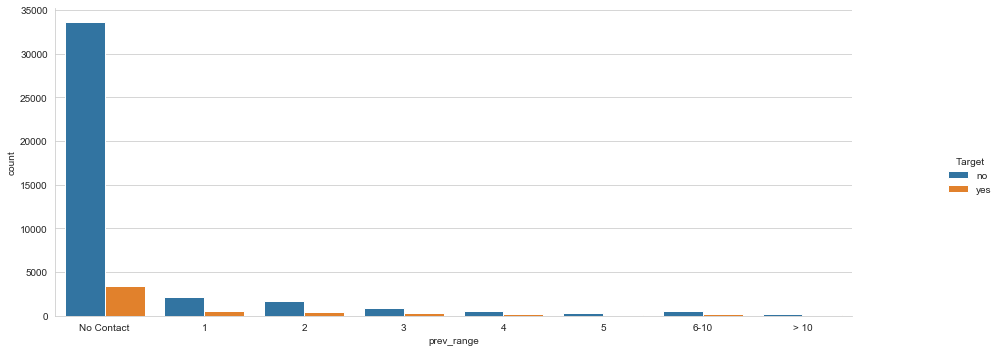

In [33]:
# Analysis of Attribute: prev_range
curattr = 'prev_range'
sns.catplot(x=curattr, hue="Target", kind="count",data=mydata);
sns.despine()
plt.gcf().set_size_inches(15, 5)
Item=[]
for val in mydata[curattr].unique():
    Item.append([
        val,
        len(mydata[mydata[curattr] == val]),
        round((len(mydata[mydata[curattr] == val])/len(mydata[curattr]))*100,2),
        round(((len(mydata[(mydata[curattr] == val) & (mydata['Target'] == 'no')]))\
              /(len(mydata[(mydata[curattr] == val) ])))*100,2),
        round(((len(mydata[(mydata[curattr] == val) & (mydata['Target'] == 'yes')]))\
              /(len(mydata[(mydata[curattr] == val) ])))*100,2)
        
    ]);
    
curattrdf=pd.DataFrame(data=Item,columns=['Values','Count','Mix%','Target-No %','Target-Yes%'])
curattrdf.round(2).sort_values('Count',ascending=False).style.hide_index()\
                                                   .highlight_max(subset=['Count','Mix%','Target-Yes%']) 

#### Based on the above we can infer the following:

#1.Most of the customers were not contacted before this campaign. Hence conversion ratio is the lowest.
#2.Customers contacted up to 3 times before this campaign seem to show higher conversion ratio.

In [34]:
# we will apply log transformation to age attribute to handle outliers.
attr='previous'
logprev=np.log1p(np.log(mydata[attr]-(mydata[attr].min()-1)))

#update dataframe with log transformed data for attribute = 'campaign'
mydata['previous_log']=logprev
mydata.sample(5)

,age,job,marital,education,default,balance,housing,loan,contact,day,...,age_range,age_log,bal_range,dur_range,camp_range,campaign_log,pdays_range,pdays_log,prev_range,previous_log
28196,41,management,married,tertiary,no,-412,yes,no,cellular,29,...,40-49,3.178054,< 0,<= 5min,1,0.000000,181-366,1.836255,5,1.026672
24058,44,technician,single,secondary,no,1679,no,no,telephone,20,...,40-49,3.295837,1500-1999,>10min,1,0.000000,Up to 7,0.000000,No Contact,0.000000
21945,49,technician,married,secondary,no,51,no,no,cellular,20,...,40-49,3.465736,0-99,7-10min,4-5,1.386294,Up to 7,0.000000,No Contact,0.000000
23708,34,management,married,tertiary,no,2032,no,no,cellular,28,...,30-39,2.833213,2000-9999,<= 5min,>10,2.484907,Up to 7,0.000000,No Contact,0.000000
5372,43,technician,divorced,secondary,no,353,yes,no,unknown,23,...,40-49,3.258097,100-499,<= 5min,1,0.000000,Up to 7,0.000000,No Contact,0.000000


Values,Count,Mix%,Target-No %,Target-Yes%
20,2752,6.09,93.02,6.98
18,2308,5.1,90.12,9.88
21,2026,4.48,90.08,9.92
17,1939,4.29,90.92,9.08
6,1932,4.27,90.63,9.37
5,1910,4.22,88.74,11.26
14,1848,4.09,88.64,11.36
8,1842,4.07,89.09,10.91
28,1830,4.05,92.19,7.81
7,1817,4.02,91.36,8.64


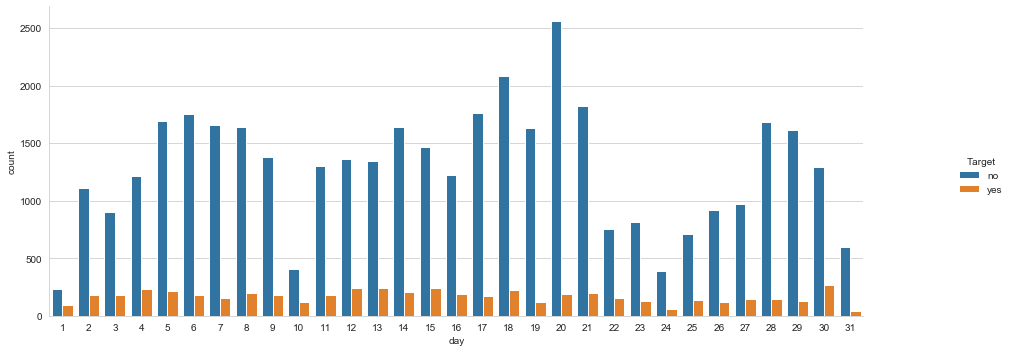

In [35]:
# Analysis of Attribute: day
curattr = 'day'
sns.catplot(x=curattr, hue="Target", kind="count",data=mydata);
sns.despine()
plt.gcf().set_size_inches(15, 5)
Item=[]
for jobs in mydata[curattr].unique():
    Item.append([
        jobs,
        len(mydata[mydata[curattr] == jobs]),
        round((len(mydata[mydata[curattr] == jobs])/len(mydata[curattr]))*100,2),
        round(((len(mydata[(mydata[curattr] == jobs) & (mydata['Target'] == 'no')]))\
              /(len(mydata[(mydata[curattr] == jobs) ])))*100,2),
        round(((len(mydata[(mydata[curattr] == jobs) & (mydata['Target'] == 'yes')]))\
              /(len(mydata[(mydata[curattr] == jobs) ])))*100,2)
        
    ]);
    
curattrdf=pd.DataFrame(data=Item,columns=['Values','Count','Mix%','Target-No %','Target-Yes%'])
curattrdf.round(2).sort_values('Count',ascending=False).style.hide_index()\
                                                   .highlight_max(subset=['Count','Mix%','Target-Yes%']) 

#### Based on the above we can infer the following:

#1.Most of the contact seems to have been made between 15-21st. 
#2.Customers contacted on 1st day of the month seem to have high conversion ratio.

Values,Count,Mix%,Target-No %,Target-Yes%
blue-collar,9732,21.53,92.73,7.27
management,9458,20.92,86.24,13.76
technician,7597,16.8,88.94,11.06
admin.,5171,11.44,87.8,12.2
services,4154,9.19,91.12,8.88
retired,2264,5.01,77.21,22.79
self-employed,1579,3.49,88.16,11.84
entrepreneur,1487,3.29,91.73,8.27
unemployed,1303,2.88,84.5,15.5
housemaid,1240,2.74,91.21,8.79


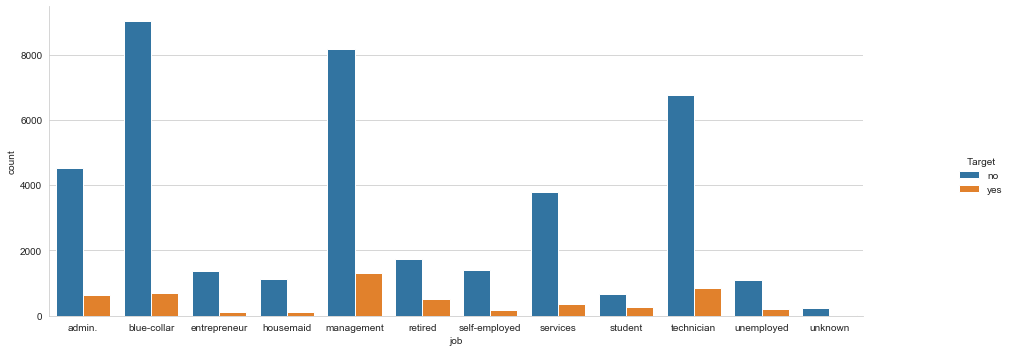

In [36]:
# Analysis of Attribute: job
curattr = 'job'
sns.catplot(x=curattr, hue="Target", kind="count",data=mydata);
sns.despine()
plt.gcf().set_size_inches(15, 5)
Item=[]
for jobs in mydata[curattr].unique():
    Item.append([
        jobs,
        len(mydata[mydata[curattr] == jobs]),
        round((len(mydata[mydata[curattr] == jobs])/len(mydata[curattr]))*100,2),
        round(((len(mydata[(mydata[curattr] == jobs) & (mydata['Target'] == 'no')]))\
              /(len(mydata[(mydata[curattr] == jobs) ])))*100,2),
        round(((len(mydata[(mydata[curattr] == jobs) & (mydata['Target'] == 'yes')]))\
              /(len(mydata[(mydata[curattr] == jobs) ])))*100,2)
        
    ]);
    
curattrdf=pd.DataFrame(data=Item,columns=['Values','Count','Mix%','Target-No %','Target-Yes%'])
curattrdf.round(2).sort_values('Count',ascending=False).style.hide_index()\
                                                   .highlight_max(subset=['Count','Mix%','Target-Yes%']) 

#### Based on the above we can infer the following 

#1.Most of the customers are blue- collor / management job holders.
#2.Conversion ratio seems to be highest among students, followed by customers who are retired.



Values,Count,Mix%,Target-No %,Target-Yes%
married,27214,60.19,89.88,10.12
single,12790,28.29,85.05,14.95
divorced,5207,11.52,88.05,11.95


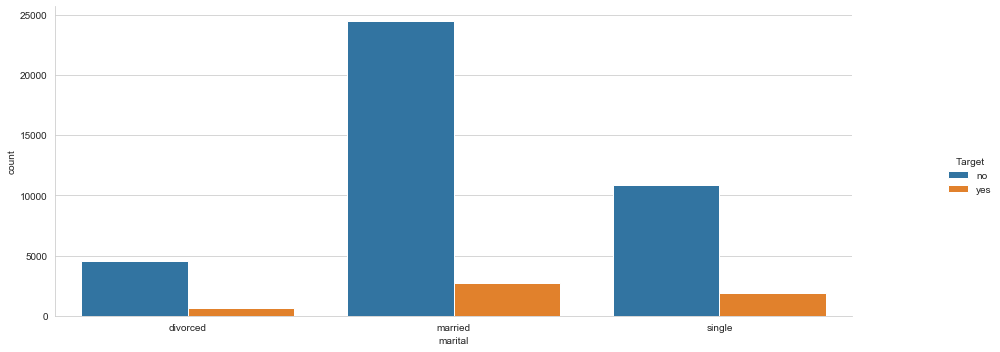

In [37]:
# Analysis of Attribute: marital
curattr = 'marital'
sns.catplot(x=curattr, hue="Target", kind="count",data=mydata);
sns.despine()
plt.gcf().set_size_inches(15, 5)
Item=[]
for jobs in mydata[curattr].unique():
    Item.append([
        jobs,
        len(mydata[mydata[curattr] == jobs]),
        round((len(mydata[mydata[curattr] == jobs])/len(mydata[curattr]))*100,2),
        round(((len(mydata[(mydata[curattr] == jobs) & (mydata['Target'] == 'no')]))\
              /(len(mydata[(mydata[curattr] == jobs) ])))*100,2),
        round(((len(mydata[(mydata[curattr] == jobs) & (mydata['Target'] == 'yes')]))\
              /(len(mydata[(mydata[curattr] == jobs) ])))*100,2)
        
    ]);
    
curattrdf=pd.DataFrame(data=Item,columns=['Values','Count','Mix%','Target-No %','Target-Yes%'])
curattrdf.round(2).sort_values('Count',ascending=False).style.hide_index()\
                                                   .highlight_max(subset=['Count','Mix%','Target-Yes%']) 

#### Based on the above we can infer the following:

#1.Most of the customers are married customers. 
#2.However conversion ratio is high among customers who are single.

Values,Count,Mix%,Target-No %,Target-Yes%
secondary,23202,51.32,89.44,10.56
tertiary,13301,29.42,84.99,15.01
primary,6851,15.15,91.37,8.63
unknown,1857,4.11,86.43,13.57


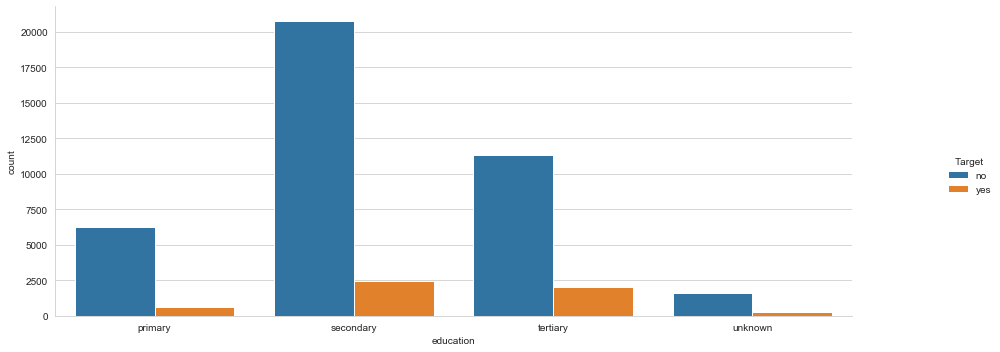

In [38]:
# Analysis of Attribute: education
curattr = 'education'
sns.catplot(x=curattr, hue="Target", kind="count",data=mydata);
sns.despine()
plt.gcf().set_size_inches(15, 5)
Item=[]
for jobs in mydata[curattr].unique():
    Item.append([
        jobs,
        len(mydata[mydata[curattr] == jobs]),
        round((len(mydata[mydata[curattr] == jobs])/len(mydata[curattr]))*100,2),
        round(((len(mydata[(mydata[curattr] == jobs) & (mydata['Target'] == 'no')]))\
              /(len(mydata[(mydata[curattr] == jobs) ])))*100,2),
        round(((len(mydata[(mydata[curattr] == jobs) & (mydata['Target'] == 'yes')]))\
              /(len(mydata[(mydata[curattr] == jobs) ])))*100,2)
        
    ]);
    
curattrdf=pd.DataFrame(data=Item,columns=['Values','Count','Mix%','Target-No %','Target-Yes%'])
curattrdf.round(2).sort_values('Count',ascending=False).style.hide_index()\
                                                   .highlight_max(subset=['Count','Mix%','Target-Yes%']) 

#### Based on the above we can infer the following:

#1.Most of the customers have secondary education. 
#2.However conversion ratio is highest among customers with tertiary education level.

Values,Count,Mix%,Target-No %,Target-Yes%
no,44396,98.2,88.2,11.8
yes,815,1.8,93.62,6.38


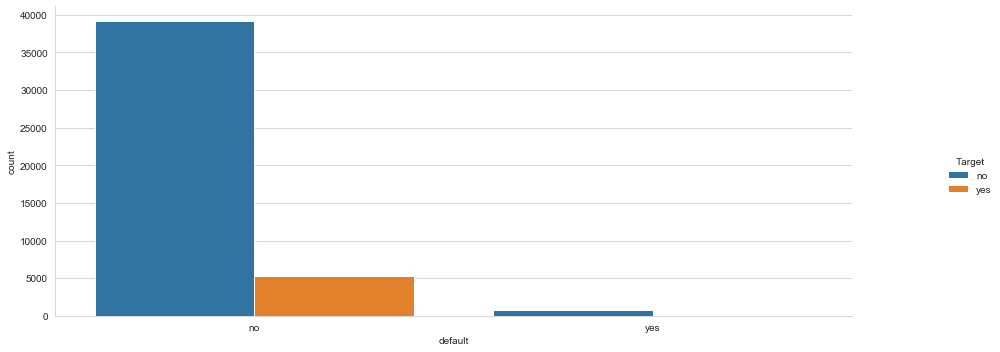

In [39]:
# Analysis of Attribute: default
curattr = 'default'
sns.catplot(x=curattr, hue="Target", kind="count",data=mydata);
sns.despine()
plt.gcf().set_size_inches(15, 5)
Item=[]
for jobs in mydata[curattr].unique():
    Item.append([
        jobs,
        len(mydata[mydata[curattr] == jobs]),
        round((len(mydata[mydata[curattr] == jobs])/len(mydata[curattr]))*100,2),
        round(((len(mydata[(mydata[curattr] == jobs) & (mydata['Target'] == 'no')]))\
              /(len(mydata[(mydata[curattr] == jobs) ])))*100,2),
        round(((len(mydata[(mydata[curattr] == jobs) & (mydata['Target'] == 'yes')]))\
              /(len(mydata[(mydata[curattr] == jobs) ])))*100,2)
        
    ]);
    
curattrdf=pd.DataFrame(data=Item,columns=['Values','Count','Mix%','Target-No %','Target-Yes%'])
curattrdf.round(2).sort_values('Count',ascending=False).style.hide_index()\
                                                   .highlight_max(subset=['Count','Mix%','Target-Yes%']) 

#### Based on the above we can infer the following:

#1.Most of the data relates to customers who have not defaulted (98.2%).
#2.Since the composition of customers with default is less than 2%, this attribute can be ignored for model building.




In [40]:
del(mydata['default'])
mydata.sample(5)

,age,job,marital,education,balance,housing,loan,contact,day,month,...,age_range,age_log,bal_range,dur_range,camp_range,campaign_log,pdays_range,pdays_log,prev_range,previous_log
2621,32,blue-collar,single,secondary,1940,yes,yes,unknown,13,may,...,30-39,2.708050,1500-1999,<= 5min,3,1.098612,Up to 7,0.0,No Contact,0.0
26757,52,admin.,divorced,secondary,361,no,yes,cellular,20,nov,...,50-59,3.555348,100-499,<= 5min,1,0.000000,Up to 7,0.0,No Contact,0.0
4769,36,technician,married,secondary,8119,no,no,unknown,21,may,...,30-39,2.944439,2000-9999,<= 5min,1,0.000000,Up to 7,0.0,No Contact,0.0
22786,33,technician,single,secondary,291,no,no,cellular,25,aug,...,30-39,2.772589,100-499,<= 5min,6-10,1.791759,Up to 7,0.0,No Contact,0.0
24483,32,management,married,tertiary,81,yes,no,cellular,17,nov,...,30-39,2.708050,0-99,<= 5min,1,0.000000,Up to 7,0.0,No Contact,0.0


Values,Count,Mix%,Target-No %,Target-Yes%
yes,25130,55.58,92.3,7.7
no,20081,44.42,83.3,16.7


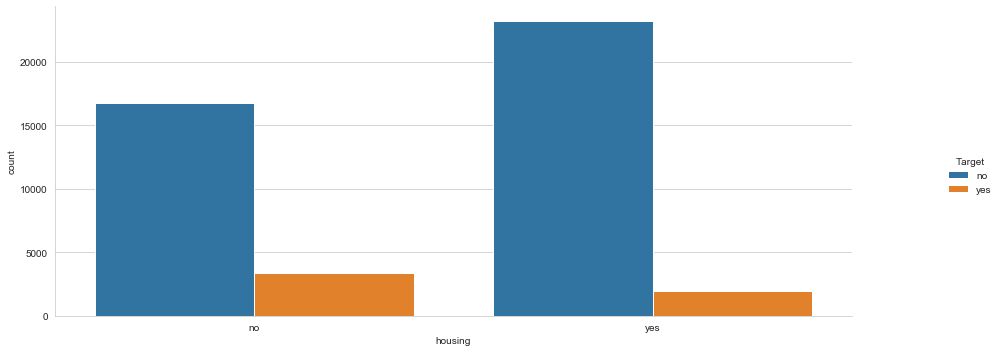

In [41]:
# Analysis of Attribute: housing
curattr = 'housing'
sns.catplot(x=curattr, hue="Target", kind="count",data=mydata);
sns.despine()
plt.gcf().set_size_inches(15, 5)
Item=[]
for jobs in mydata[curattr].unique():
    Item.append([
        jobs,
        len(mydata[mydata[curattr] == jobs]),
        round((len(mydata[mydata[curattr] == jobs])/len(mydata[curattr]))*100,2),
        round(((len(mydata[(mydata[curattr] == jobs) & (mydata['Target'] == 'no')]))\
              /(len(mydata[(mydata[curattr] == jobs) ])))*100,2),
        round(((len(mydata[(mydata[curattr] == jobs) & (mydata['Target'] == 'yes')]))\
              /(len(mydata[(mydata[curattr] == jobs) ])))*100,2)
        
    ]);
    
curattrdf=pd.DataFrame(data=Item,columns=['Values','Count','Mix%','Target-No %','Target-Yes%'])
curattrdf.round(2).sort_values('Count',ascending=False).style.hide_index()\
                                                   .highlight_max(subset=['Count','Mix%','Target-Yes%']) 

#### Based on the above we can infer the following:

#1.Distribution of customers with / without housing loan is more or less equal(56 - 44)
#2.Conversion rate is higher among customers who have not taken housing loan.

Values,Count,Mix%,Target-No %,Target-Yes%
no,37967,83.98,87.34,12.66
yes,7244,16.02,93.32,6.68


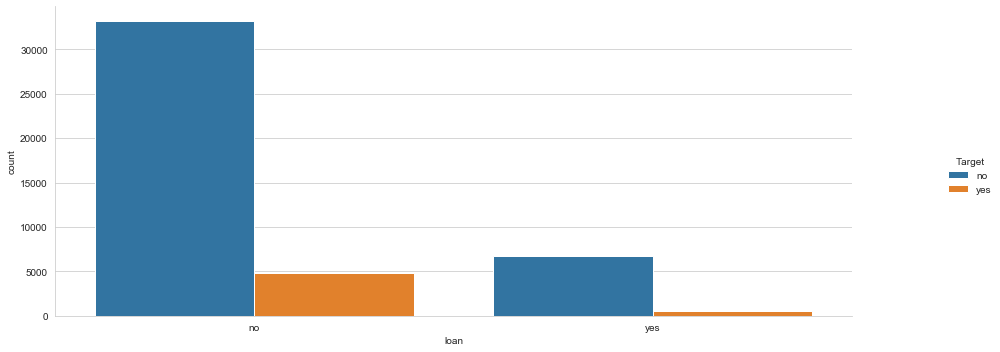

In [42]:
# Analysis of Attribute: loan
curattr = 'loan'
sns.catplot(x=curattr, hue="Target", kind="count",data=mydata);
sns.despine()
plt.gcf().set_size_inches(15, 5)
Item=[]
for jobs in mydata[curattr].unique():
    Item.append([
        jobs,
        len(mydata[mydata[curattr] == jobs]),
        round((len(mydata[mydata[curattr] == jobs])/len(mydata[curattr]))*100,2),
        round(((len(mydata[(mydata[curattr] == jobs) & (mydata['Target'] == 'no')]))\
              /(len(mydata[(mydata[curattr] == jobs) ])))*100,2),
        round(((len(mydata[(mydata[curattr] == jobs) & (mydata['Target'] == 'yes')]))\
              /(len(mydata[(mydata[curattr] == jobs) ])))*100,2)
        
    ]);
    
curattrdf=pd.DataFrame(data=Item,columns=['Values','Count','Mix%','Target-No %','Target-Yes%'])
curattrdf.round(2).sort_values('Count',ascending=False).style.hide_index()\
                                                   .highlight_max(subset=['Count','Mix%','Target-Yes%']) 

#### Based on the above we can infer the following:

#1.Most of the customers have not taken personal loan.
#2.Conversion ratio is higher among customers who have not taken personal loan.

Values,Count,Mix%,Target-No %,Target-Yes%
cellular,29285,64.77,85.08,14.92
unknown,13020,28.8,95.93,4.07
telephone,2906,6.43,86.58,13.42


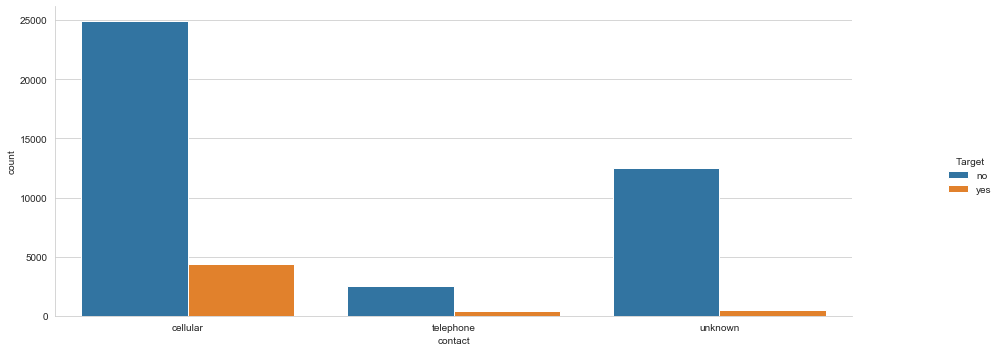

In [43]:
# Analysis of Attribute: contact
curattr = 'contact'
sns.catplot(x=curattr, hue="Target", kind="count",data=mydata);
sns.despine()
plt.gcf().set_size_inches(15, 5)
Item=[]
for jobs in mydata[curattr].unique():
    Item.append([
        jobs,
        len(mydata[mydata[curattr] == jobs]),
        round((len(mydata[mydata[curattr] == jobs])/len(mydata[curattr]))*100,2),
        round(((len(mydata[(mydata[curattr] == jobs) & (mydata['Target'] == 'no')]))\
              /(len(mydata[(mydata[curattr] == jobs) ])))*100,2),
        round(((len(mydata[(mydata[curattr] == jobs) & (mydata['Target'] == 'yes')]))\
              /(len(mydata[(mydata[curattr] == jobs) ])))*100,2)
        
    ]);
    
curattrdf=pd.DataFrame(data=Item,columns=['Values','Count','Mix%','Target-No %','Target-Yes%'])
curattrdf.round(2).sort_values('Count',ascending=False).style.hide_index()\
                                                   .highlight_max(subset=['Count','Mix%','Target-Yes%']) 

#### Based on the above we can infer the following:

#1.Most of the customers have been contacted over mobile and this channel has higher conversion ratio.

Values,Count,Mix%,Target-No %,Target-Yes%
may,13766,30.45,93.28,6.72
jul,6895,15.25,90.91,9.09
aug,6247,13.82,88.99,11.01
jun,5341,11.81,89.78,10.22
nov,3970,8.78,89.85,10.15
apr,2932,6.49,80.32,19.68
feb,2649,5.86,83.35,16.65
jan,1403,3.1,89.88,10.12
oct,738,1.63,56.23,43.77
sep,579,1.28,53.54,46.46


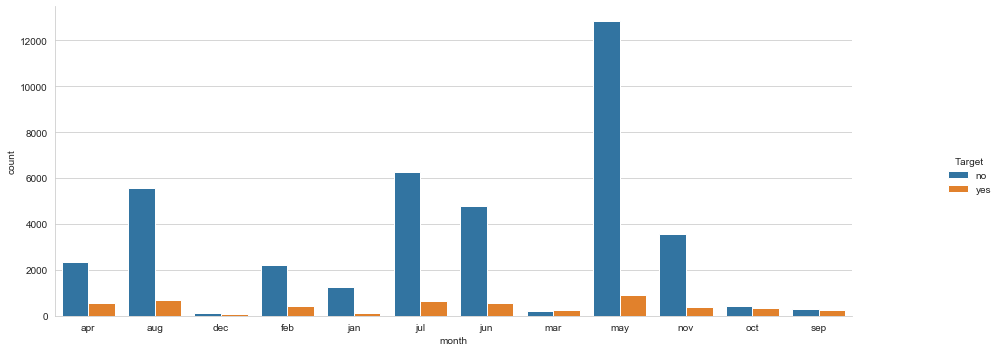

In [44]:
# Analysis of Attribute: month
curattr = 'month'
sns.catplot(x=curattr, hue="Target", kind="count",data=mydata);
sns.despine()
plt.gcf().set_size_inches(15, 5)
Item=[]
for jobs in mydata[curattr].unique():
    Item.append([
        jobs,
        len(mydata[mydata[curattr] == jobs]),
        round((len(mydata[mydata[curattr] == jobs])/len(mydata[curattr]))*100,2),
        round(((len(mydata[(mydata[curattr] == jobs) & (mydata['Target'] == 'no')]))\
              /(len(mydata[(mydata[curattr] == jobs) ])))*100,2),
        round(((len(mydata[(mydata[curattr] == jobs) & (mydata['Target'] == 'yes')]))\
              /(len(mydata[(mydata[curattr] == jobs) ])))*100,2)
        
    ]);
    
curattrdf=pd.DataFrame(data=Item,columns=['Values','Count','Mix%','Target-No %','Target-Yes%'])
curattrdf.round(2).sort_values('Count',ascending=False).style.hide_index()\
                                                   .highlight_max(subset=['Count','Mix%','Target-Yes%']) 

#### Based on the above we can infer the following:

#1.Most of the contact has been done in May month.However conversion ratio is lowest in this month.
#2.Conversion ratio is higher in Mar and towards end of the year (Sep,Oct and Dec)

Values,Count,Mix%
no,39922,88.3
yes,5289,11.7


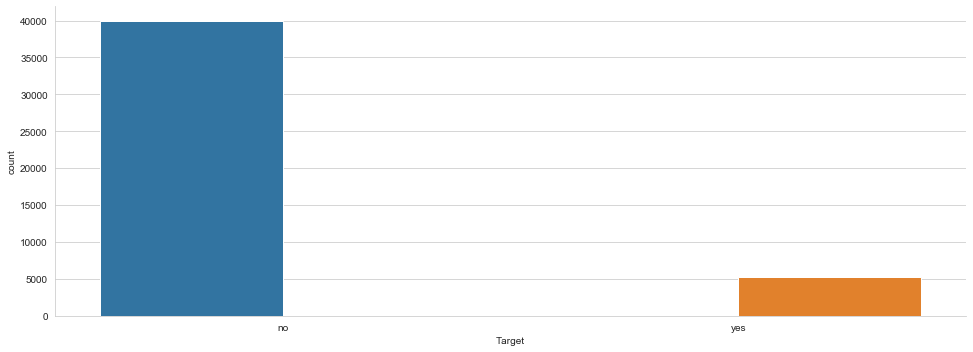

In [45]:
# Analysis of Target: target
curattr = 'Target'
sns.catplot(x=curattr, hue="Target", kind="count",data=mydata);
sns.despine()
plt.gcf().set_size_inches(15, 5)
Item=[]
for jobs in mydata[curattr].unique():
    Item.append([
        jobs,
        len(mydata[mydata[curattr] == jobs]),
        round((len(mydata[mydata[curattr] == jobs])/len(mydata[curattr]))*100,2)
        
    ]);
    
curattrdf=pd.DataFrame(data=Item,columns=['Values','Count','Mix%'])
curattrdf.round(2).sort_values('Count',ascending=False).style.hide_index()\
                                                   .highlight_max(subset=['Count','Mix%']) 

#### Based on the above we can infer the following 

#1.Target data is heavily skewed for value no (i.e customers not subscribed to bank term deposit). This needs to be balanced


In [46]:
# convert target column to number using LabelEncoder
le=LabelEncoder()
mydata['Target'] = le.fit_transform(mydata['Target'])
mydata.Target.value_counts()

0    39922
1     5289
Name: Target, dtype: int64

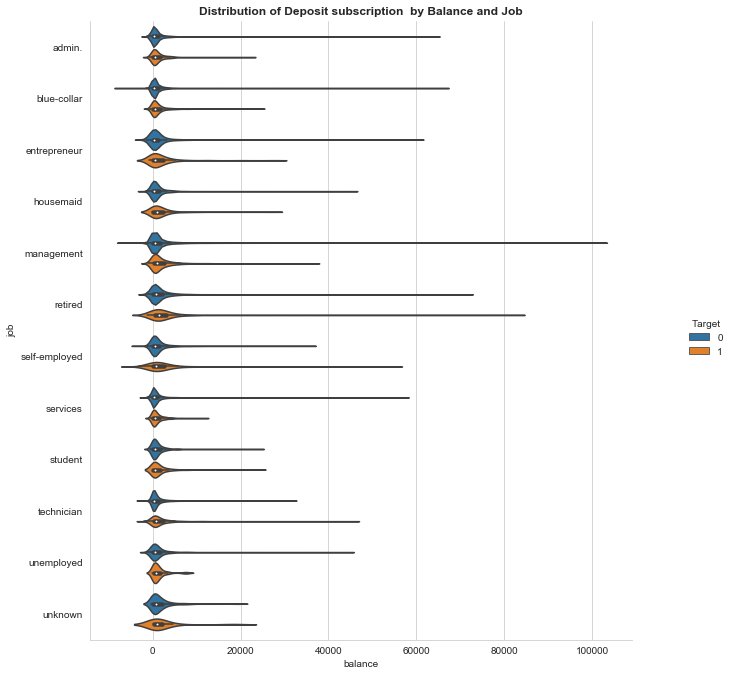

In [47]:
#Distribution of Deposit subscription  by Balance and Job
g=sns.catplot(x="balance", y="job", hue="Target",kind="violin", split=False, data=mydata)
plt.title('Distribution of Deposit subscription  by Balance and Job',fontweight="bold")
sns.despine()
plt.gcf().set_size_inches(12, 10)

#### Based on the above we can infer the following 

#1.Customers with high balances belong to Management though , the ones with high balances do not opt for term deposit subsription. This could be becuase of their risk appetite as they could invest in other investments yielding better returns though risk is on the higher side.
#2.Next are the customers who are retired and understandably , those customers who have taken term deposits are more . This could be because of their need for steady income without taking too much risk

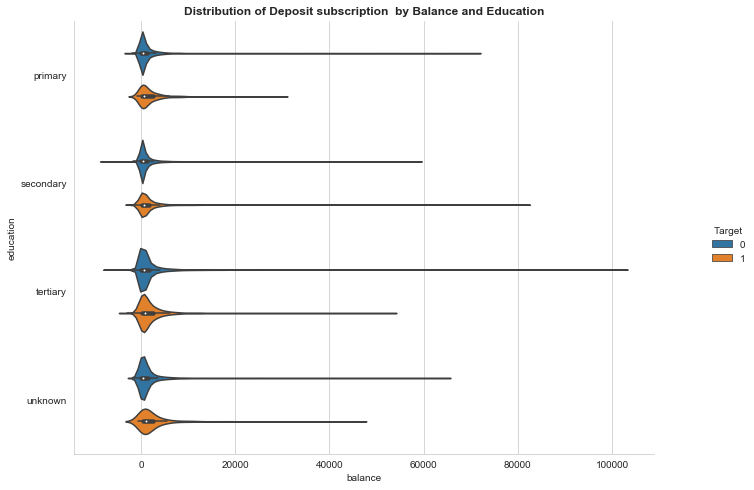

In [48]:
#Distribution of Deposit subscription  by Balance and Education
g=sns.catplot(x="balance", y="education", hue="Target",kind="violin", split=False, data=mydata)
plt.title('Distribution of Deposit subscription  by Balance and Education',fontweight="bold")
sns.despine()
plt.gcf().set_size_inches(12, 7)

#### Based on the above we can infer the following 

#1.Customers with high balances belong to tertiary eduction ,though the ones with high balances do not opt for term deposit subsription. 
#2.Next are the customers who have secondary education, and among them those customers who have taken term deposits are more .

In [49]:
# creating data frame by converting categorical variables in to integers using label encoder

data_dt = mydata[['age', 'job', 'marital', 'education', 'balance','duration', \
                 'housing', 'loan','contact', 'day', 'month', \
                 'campaign', 'pdays', 'previous',\
                 'poutcome', 'Target']].copy()

le=LabelEncoder()
catcol = ['job', 'marital', 'education','housing','loan', 'contact','month',  'poutcome','day']

for col in catcol:
    data_dt[col] = le.fit_transform(data_dt[col]);


data_dt.head(5)

,age,job,marital,education,balance,duration,housing,loan,contact,day,month,campaign,pdays,previous,poutcome,Target
0,58,4,1,2,2143,261,1,0,2,4,8,1,1,0,3,0
1,44,9,2,1,29,151,1,0,2,4,8,1,1,0,3,0
2,33,2,1,1,2,76,1,1,2,4,8,1,1,0,3,0
3,47,1,1,3,1506,92,1,0,2,4,8,1,1,0,3,0
4,33,11,2,3,1,198,0,0,2,4,8,1,1,0,3,0


In [50]:
# creating a dataframe with sample of 1000 records ( since volume is high)for the purpose of multivariate analysis
data_dt_r=data_dt.sample(1000,random_state=9,replace=True)
data_dt_r.head()

,age,job,marital,education,balance,duration,housing,loan,contact,day,month,campaign,pdays,previous,poutcome,Target
20828,39,9,1,2,4373,78,1,0,0,12,1,6,1,0,3,0
501,32,9,2,3,-170,46,0,0,2,5,8,1,1,0,3,0
22584,53,10,0,1,468,153,0,0,0,21,1,6,1,0,3,0
42747,71,11,1,2,353,208,0,0,0,26,4,1,93,2,0,0
5014,28,9,2,1,2034,196,1,0,2,20,8,1,1,0,3,0


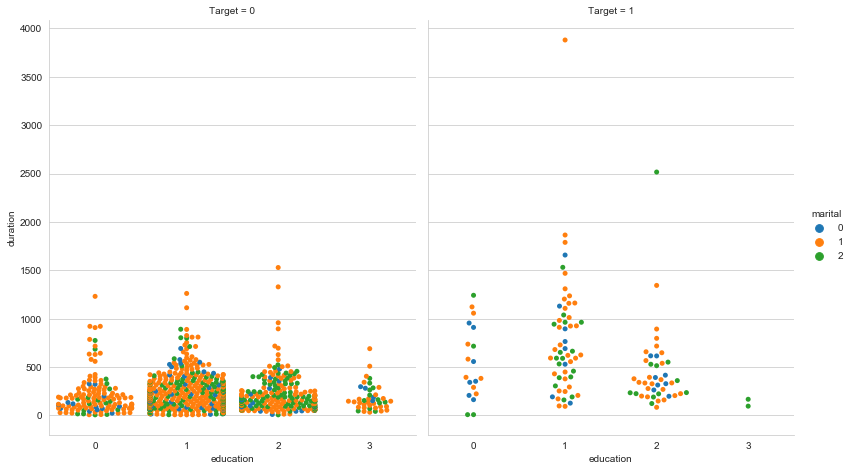

In [51]:
# distribution of duration by education, target and marital status

g=sns.catplot(x='education',y='duration',col='Target',hue ='marital',kind='swarm',data=data_dt_r)
sns.despine()
plt.gcf().set_size_inches(12, 7)

#### Based on the above we can infer the following 
#1.As the call duration increases above certain level ( around 10 min / 600 sec), the proportion of customers taking loan is more. Among them those with education level 1 and marital status 1 is more

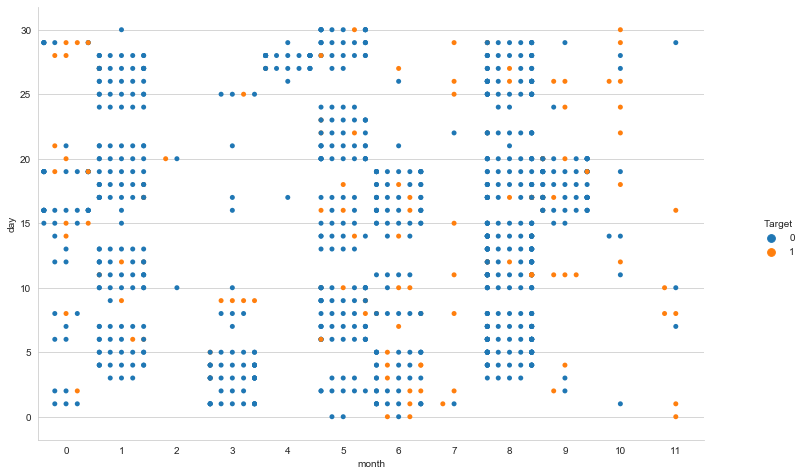

In [52]:
# distribution of target by day and month

g=sns.catplot(x='month',y='day',hue ='Target',kind='swarm',data=data_dt_r)
sns.despine()
plt.gcf().set_size_inches(12, 7)

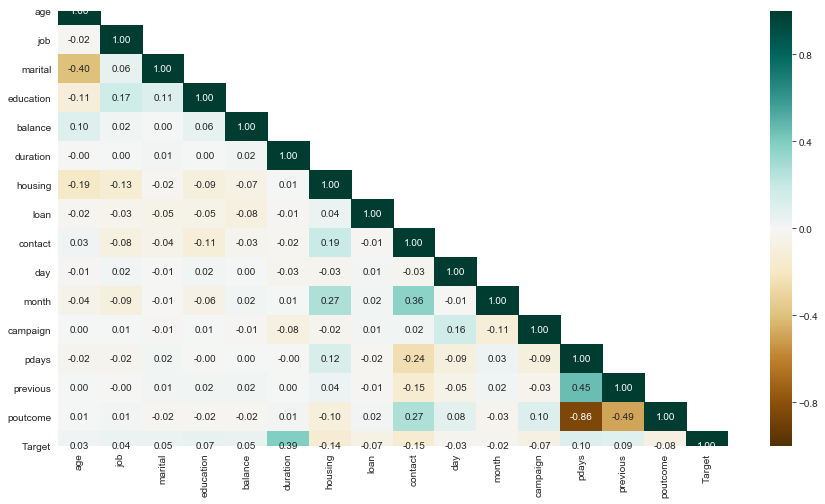

In [53]:
#Correlation analysis

corr = data_dt.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask, 1)] = True
a = sns.heatmap(corr,mask=mask, annot=True, cmap="BrBG",fmt='.2f',vmin=-1,vmax=1)
rotx = a.set_xticklabels(a.get_xticklabels(), rotation=90)
roty = a.set_yticklabels(a.get_yticklabels(), rotation=0)
plt.gcf().set_size_inches(15, 8)

#### Based on the above we can infer the following 

#1.None of the features above seem to have statistically significant correlation with Target.
#2.Duration seems to have some degreee of correlation with Target but not significant enough. However this should not be used for prediction model
#3.'Previous' and 'poutcome'  features seems to have correlation with 'pdays'.
#4. It appears that while individual attributes do not influence Target , all the variables put together have influence on target and hence it will be difficult to drop any column based on above analysis


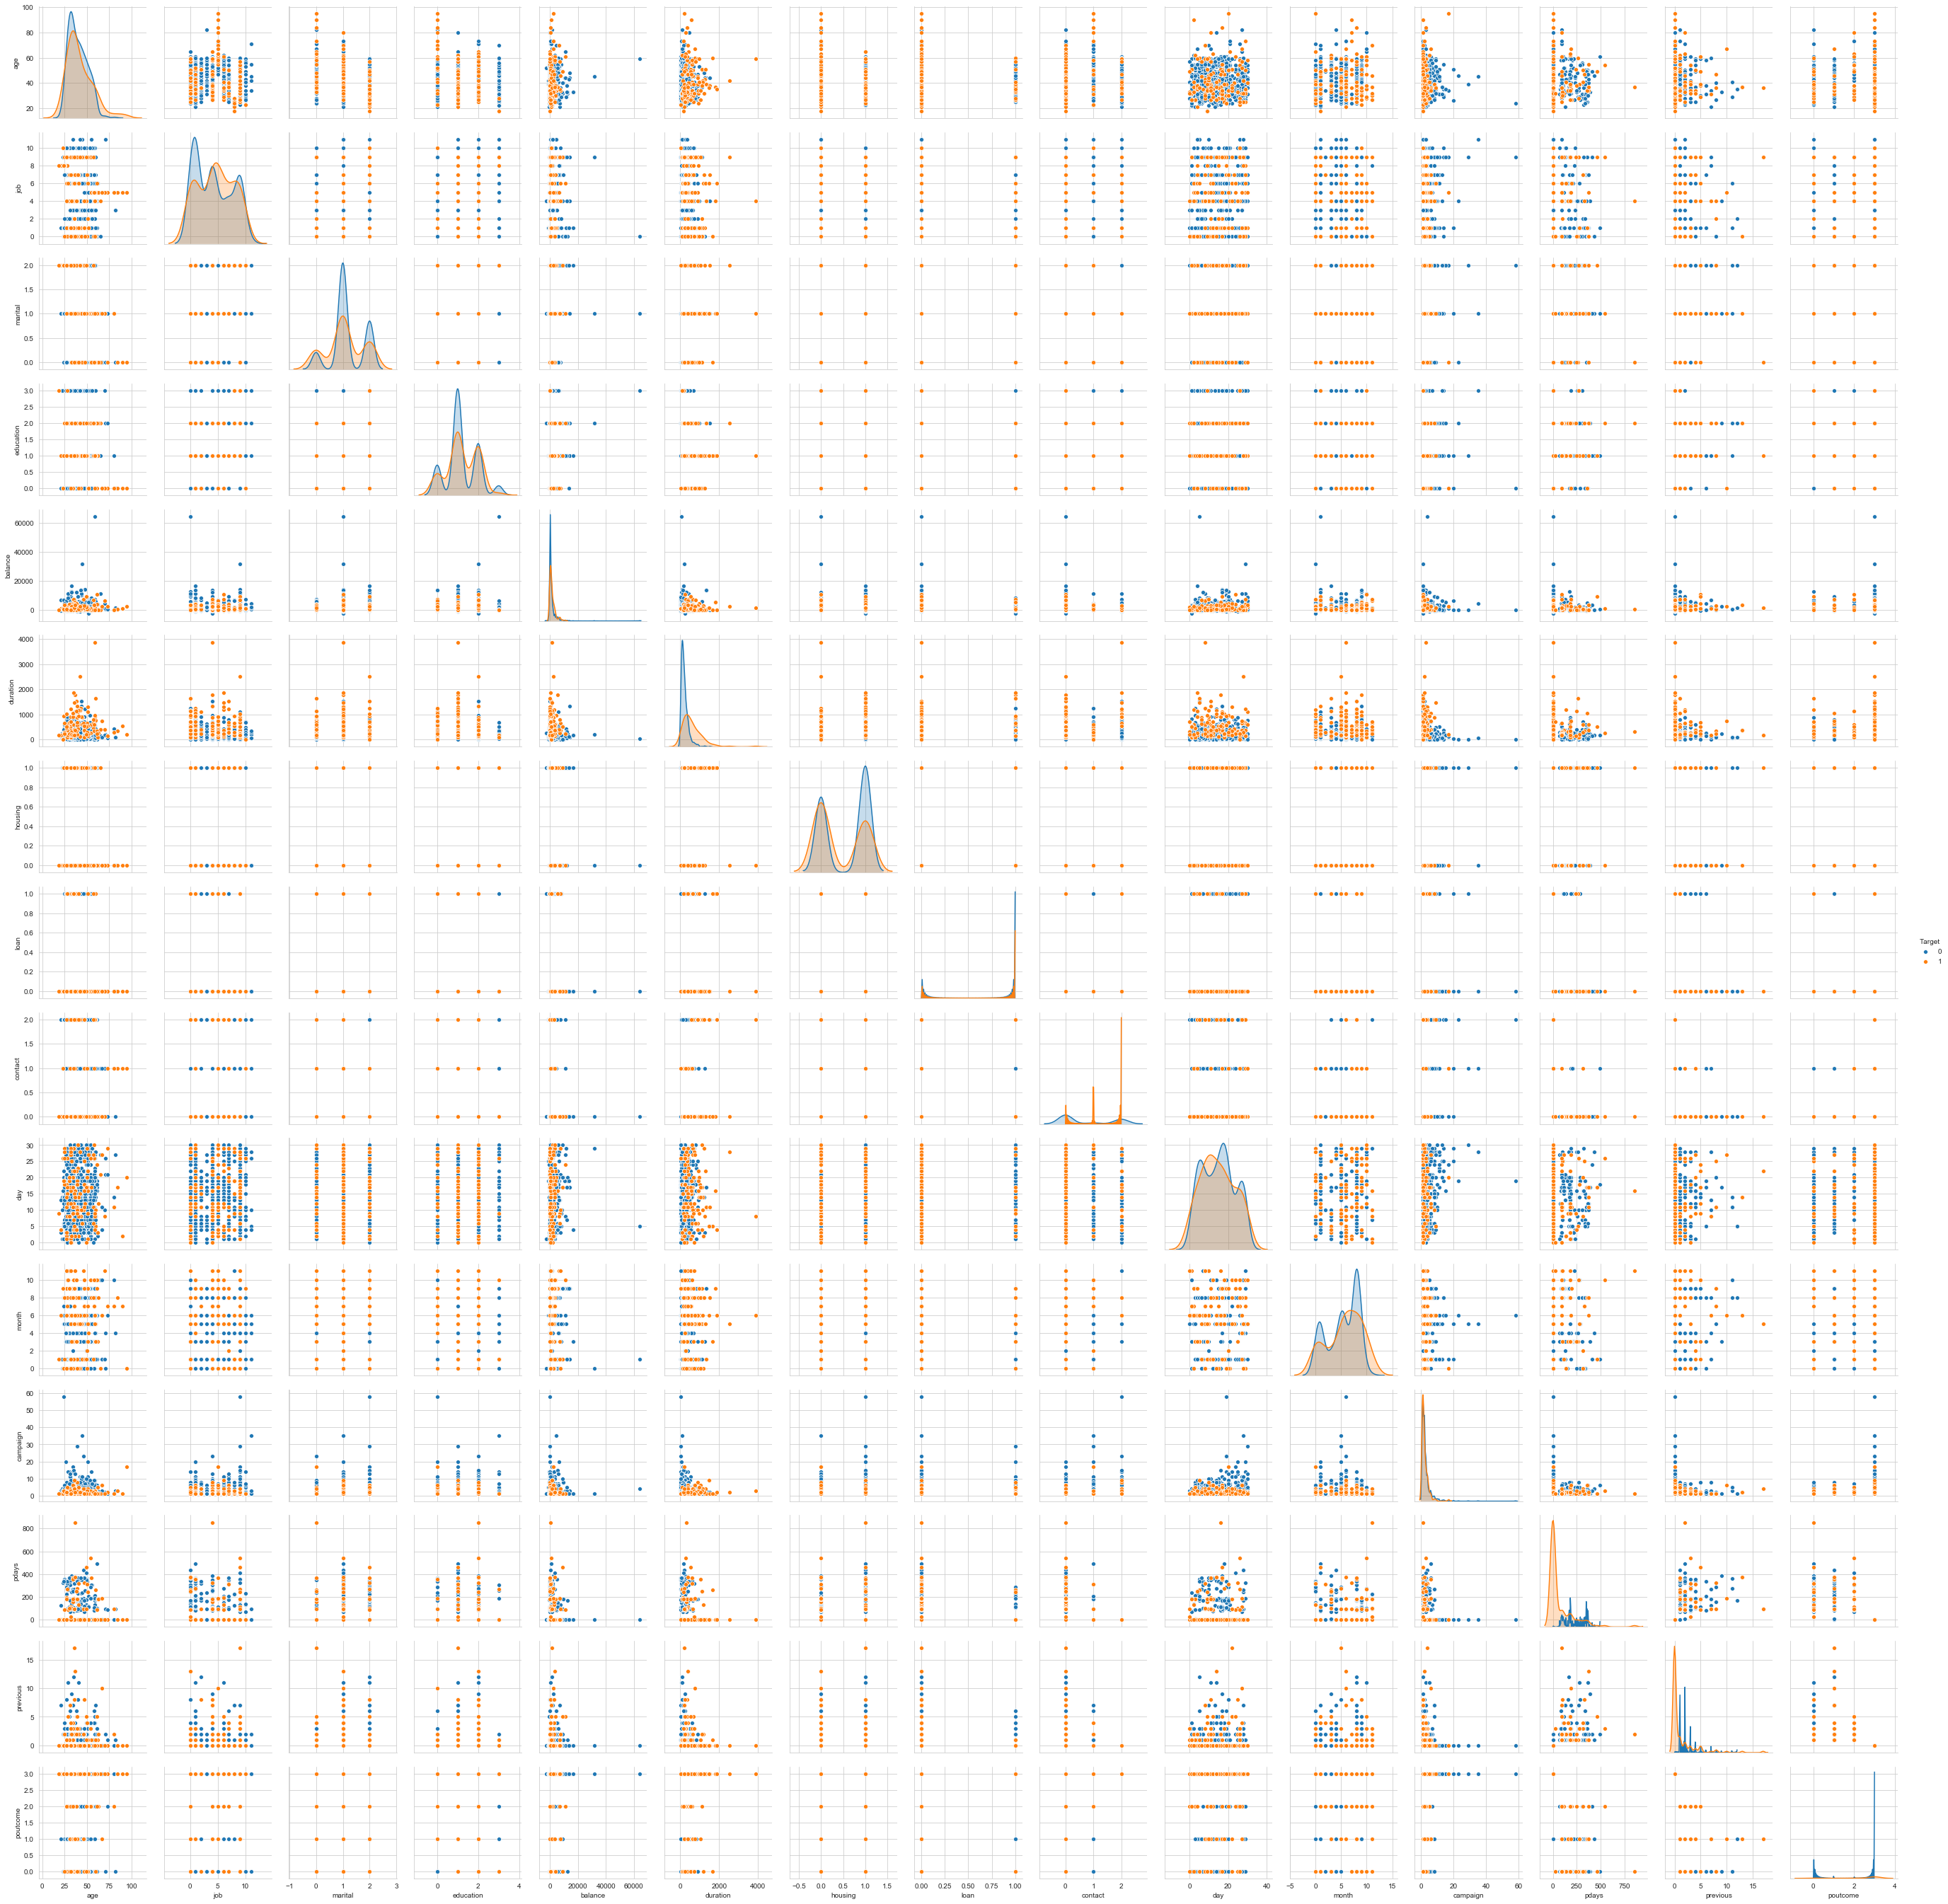

In [54]:
# pairplot
sns.pairplot(data=data_dt_r,vars=['age', 'job', 'marital', 'education', 'balance', 'duration','housing', 'loan',
       'contact', 'day', 'month', 'campaign', 'pdays', 'previous',
       'poutcome'],diag_kind='kde',hue='Target')

#### Based on the above we can infer the following 

#1. There is no liner relationship between any attibutes.
#2. Diag show that multiple gaussians overlap and there is no clear distribution which separates classes.
#3. Usage of PCA may not be effective as no attributes show linear relationship.

## 4. Feature Selection and Engineering

In [55]:
# Test the significance of influence of all the attributes on Target using Chi square test 

attr=list(data_dt.columns)
del attr[attr.index('Target')]
Item=[]
for val in attr:
    cont=pd.crosstab(data_dt[val],data_dt['Target'])
    chi2,p,df,expected=stats.chi2_contingency(cont)
    Item.append([
        val,
        '%1.2f' %(p),
    ]);
    
chidf=pd.DataFrame(data=Item,columns=['Attribute','P Value'])
chidf.head(20)

,Attribute,P Value
0,age,0.00
1,job,0.00
2,marital,0.00
3,education,0.00
4,balance,0.00
5,duration,0.00
6,housing,0.00
7,loan,0.00
8,contact,0.00
9,day,0.00


#### Based on the above we can infer the following 

#1.Since p value is less than 0.05, H0 is rejected. All the attributes have significant statistical influence on Target

Number of features for .95 level is: 13


Text(0, 0.5, 'Cumulative explained variance')

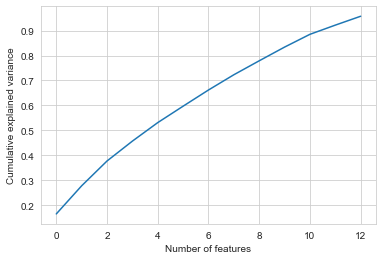

In [56]:
# Using PCA for checking spread of features for 95% variance explanation

s= data_dt
tind=len(s.columns)-1
array=s.values
X=array[:,0:tind]
y=array[:,[tind]]


#creating train test split
X_train,X_test,y_train,y_test= train_test_split(X,y,test_size=0.3,random_state=9)

# Feature Scaling
sc= StandardScaler()
X_train= sc.fit_transform(X_train)
X_test = sc.transform(X_test)


pca = PCA(.95)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)
explained_variance = pca.explained_variance_ratio_
print("Number of features for .95 level is: %s" % pca.n_components_)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of features')
plt.ylabel('Cumulative explained variance')

In [57]:
# Using RFE for feature selection

data_dt_z = data_dt.apply(zscore)
arrayX=data_dt_z.values
arrayy=data_dt.values
tind=len(data_dt_z.columns)-1
X=arrayX[:,0:tind]
y=arrayy[:,[tind]]
classifier = LogisticRegression(random_state=9,solver='lbfgs',max_iter=20000)
rfe = RFE(classifier,n_features_to_select =13)
rfe = rfe.fit(X,y.ravel())
rfesupport=pd.DataFrame(rfe.support_)
rferanking=pd.DataFrame(rfe.ranking_)
features=pd.DataFrame(data_dt_z.columns)
RFEFeatureScore=pd.concat([features,rfesupport,rferanking],axis=1)
RFEFeatureScore.columns=['Feature','Support','Ranking']
RFEFeatureScore.sort_values(by='Ranking')

,Feature,Support,Ranking
0,age,True,1.0
2,marital,True,1.0
3,education,True,1.0
4,balance,True,1.0
5,duration,True,1.0
6,housing,True,1.0
7,loan,True,1.0
8,contact,True,1.0
10,month,True,1.0
11,campaign,True,1.0


In [58]:
# Using Decision Tree for feature importance identification 

# with scaled data

s= data_dt
tind=len(s.columns)-1
array=s.values
X=array[:,0:tind]
y=array[:,[tind]]


#creating train test split
X_train,X_test,y_train,y_test= train_test_split(X,y,test_size=0.3,random_state=9)

# Feature Scaling
sc= StandardScaler()
X_train= sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Class balancing using SMOTE
sm = SMOTE(random_state=9)
X_train_bal, y_train_bal = sm.fit_sample(X_train, y_train.ravel())

# Train and test the model


seed = 9

model = DecisionTreeClassifier(criterion='entropy',random_state=seed)
model.fit(X_train_bal, y_train_bal)
df_fimp1=pd.DataFrame(np.array([model.feature_importances_]),columns=[np.array(data_dt.columns[0:-1])])
df_fimp1.index=['Feature Importance(DT - scaled)']

# without scaled data


#creating train test split
X_train,X_test,y_train,y_test= train_test_split(X,y,test_size=0.3,random_state=9)

# Class balancing using SMOTE
sm = SMOTE(random_state=9)
X_train_bal, y_train_bal = sm.fit_sample(X_train, y_train.ravel())

# Train and test the model


seed = 9

model = DecisionTreeClassifier(criterion='entropy',random_state=seed)
model.fit(X_train_bal, y_train_bal)
df_fimp2=pd.DataFrame(np.array([model.feature_importances_]),columns=[np.array(data_dt.columns[0:-1])])
df_fimp2.index=['Feature Importance(DT - not scaled)']

df_fimp = pd.concat([df_fimp2, df_fimp1], axis=0)
df_fimp.head().transpose().round(2)

,Feature Importance(DT - not scaled),Feature Importance(DT - scaled)
age,0.06,0.05
job,0.04,0.03
marital,0.02,0.01
education,0.02,0.02
balance,0.08,0.06
duration,0.33,0.32
housing,0.09,0.04
loan,0.02,0.01
contact,0.09,0.09
day,0.07,0.06


#### Based on the above we can infer the following 
#1. Above analysis shows that with scaling the importance of feature changes.
#2. However duration as a feature seems to be the one of highest importance under both the approach.
#3. As per the problem statement, this feature cannot be used for model building.
#4. If this feature is dropped the importance of other features will change, as can be seen from below

In [59]:
s= data_dt.drop('duration',axis=1)
tind=len(s.columns)-1
array=s.values
X=array[:,0:tind]
y=array[:,[tind]]


#creating train test split
X_train,X_test,y_train,y_test= train_test_split(X,y,test_size=0.3,random_state=9)

# Feature Scaling
sc= StandardScaler()
X_train= sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Class balancing using SMOTE
sm = SMOTE(random_state=9)
X_train_bal, y_train_bal = sm.fit_sample(X_train, y_train.ravel())

# Train and test the model


seed = 9

model = DecisionTreeClassifier(criterion='entropy',random_state=seed)
model.fit(X_train_bal, y_train_bal)
df_fimp3=pd.DataFrame(np.array([model.feature_importances_]),columns=[np.array(s.columns[0:-1])])
df_fimp3.index=['Feature Importance(DT)']

df_fimp3.transpose().round(2)

,Feature Importance(DT)
age,0.09
job,0.05
marital,0.02
education,0.04
balance,0.10
housing,0.02
loan,0.01
contact,0.08
day,0.10
month,0.14


### Various approachs for data pre processing

3 sets of dataframes will be created as described below:

#1. data_dt : Decision tree based algorithms are not impacted by outliers. Hence this dataframe will have original data with original attributes. Numeric attributes will be retained as it is and categorical attributes will be converted to numbers using label encoders
#2. data_cb : Catboost is algorithm that will use categorical values as it is. hence for this algorithm categorical values will be retained as it is
#3. data_rg : For all other algorithms that are impacted by outliers this dataframe will have numerical data , as transformed(using log) and categorical data converted to numbers using pandas get dummies function





In [60]:
# data_dt is already created. However we need to drop 'duration' feature as it is not expected to be used for model building

data_dt.drop('duration',axis=1,inplace=True)
data_dt.head(5)

,age,job,marital,education,balance,housing,loan,contact,day,month,campaign,pdays,previous,poutcome,Target
0,58,4,1,2,2143,1,0,2,4,8,1,1,0,3,0
1,44,9,2,1,29,1,0,2,4,8,1,1,0,3,0
2,33,2,1,1,2,1,1,2,4,8,1,1,0,3,0
3,47,1,1,3,1506,1,0,2,4,8,1,1,0,3,0
4,33,11,2,3,1,0,0,2,4,8,1,1,0,3,0


In [61]:
data_cb = mydata[['age_log', 'job', 'marital', 'education', 'bal_range',\
                  'housing', 'loan','contact', 'day', 'month', \
                  'campaign_log', 'pdays_log', 'previous_log','poutcome','Target']].copy()
data_cb.head(5)

,age_log,job,marital,education,bal_range,housing,loan,contact,day,month,campaign_log,pdays_log,previous_log,poutcome,Target
0,3.713572,management,married,tertiary,2000-9999,yes,no,unknown,5,may,0.0,0.0,0.0,unknown,0
1,3.295837,technician,single,secondary,0-99,yes,no,unknown,5,may,0.0,0.0,0.0,unknown,0
2,2.772589,entrepreneur,married,secondary,0-99,yes,yes,unknown,5,may,0.0,0.0,0.0,unknown,0
3,3.401197,blue-collar,married,unknown,1500-1999,yes,no,unknown,5,may,0.0,0.0,0.0,unknown,0
4,2.772589,unknown,single,unknown,0-99,no,no,unknown,5,may,0.0,0.0,0.0,unknown,0


In [62]:
data_rg = mydata[['age_log', 'job', 'marital', 'education', 'bal_range',\
                  'housing', 'loan','contact', 'day', 'month', \
                  'campaign_log', 'pdays_log', 'previous_log','poutcome','Target']].copy()


data_rg=pd.get_dummies(data_rg,columns=['bal_range','job', 'marital', 'education', 'housing',\
                                        'loan', 'contact', 'month', 'poutcome','day'],drop_first=True)

data_rg=data_rg[['age_log','campaign_log', 'pdays_log', 'previous_log',\
       'bal_range_0-99', 'bal_range_100-499', 'bal_range_500-999',\
       'bal_range_1000-1499', 'bal_range_1500-1999', 'bal_range_2000-9999',\
       'bal_range_>= 10000', 'job_blue-collar', 'job_entrepreneur',\
       'job_housemaid', 'job_management', 'job_retired', 'job_self-employed',\
       'job_services', 'job_student', 'job_technician', 'job_unemployed',\
       'job_unknown', 'marital_married', 'marital_single',\
       'education_secondary', 'education_tertiary', 'education_unknown',\
       'housing_yes', 'loan_yes', 'contact_telephone', 'contact_unknown',\
       'month_aug', 'month_dec', 'month_feb', 'month_jan', 'month_jul',\
       'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct',\
       'month_sep', 'poutcome_other', 'poutcome_success', 'poutcome_unknown',\
       'day_2', 'day_3', 'day_4', 'day_5', 'day_6', 'day_7', 'day_8', 'day_9',\
       'day_10', 'day_11', 'day_12', 'day_13', 'day_14', 'day_15', 'day_16',\
       'day_17', 'day_18', 'day_19', 'day_20', 'day_21', 'day_22', 'day_23',\
       'day_24', 'day_25', 'day_26', 'day_27', 'day_28', 'day_29', 'day_30',\
       'day_31','Target']]
data_rg.head(5)

,age_log,campaign_log,pdays_log,previous_log,bal_range_0-99,bal_range_100-499,bal_range_500-999,bal_range_1000-1499,bal_range_1500-1999,bal_range_2000-9999,...,day_23,day_24,day_25,day_26,day_27,day_28,day_29,day_30,day_31,Target
0,3.713572,0.0,0.0,0.0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,3.295837,0.0,0.0,0.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2.772589,0.0,0.0,0.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3.401197,0.0,0.0,0.0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,2.772589,0.0,0.0,0.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0



## 5. Model Building and Evaluation

In [63]:
# setting up function for measuring specificity as scoring parameter
def evaluate(y_test,y_pred):
    tp,fp,fn,tn=metrics.confusion_matrix(y_test,y_pred).ravel()
    spec=tn/(tn+fn)
    return spec

#setting up common parameters
seed = 9
n_jobs=4
pre_dispatch=8
scoring=metrics.make_scorer(evaluate,greater_is_better=True)
cv=5


### 5.1 Base Model evaluation without hyper parameter tuning

In [64]:
# Base model after applying scaling ( Non Decision Tree based models)

s= data_rg
tind=len(s.columns)-1
array=s.values
X=array[:,0:tind]
y=array[:,[tind]]


#creating train test split
X_train,X_test,y_train,y_test= train_test_split(X,y,test_size=0.3,random_state=9)

# Feature Scaling
sc= StandardScaler()
X_train= sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Class balancing using SMOTE
sm = SMOTE(random_state=9)
X_train_bal, y_train_bal = sm.fit_sample(X_train, y_train.ravel())

# Train and test the model

mlist=[0,1,2,3,4,5]

for m in mlist:
    start_time=time.time()        
    if m == 0:
        model = KNeighborsClassifier(n_neighbors=5,weights='distance',n_jobs=n_jobs)
        mname = 'KNN'
    elif m == 1:
        model = DecisionTreeClassifier(criterion='entropy',random_state=seed)
        mname = 'DT2'
    elif m == 2:
        model = LogisticRegression(solver='lbfgs',max_iter=20000,n_jobs=n_jobs,random_state=seed)
        mname = 'LR'
    elif m == 3:
        model = GaussianNB()
        mname = 'NB'
    elif m == 4:
        model = RidgeClassifier()
        mname = 'RC'        
    else:
        model = SVC(C=1,kernel='rbf',random_state=seed,probability=False)
        mname = 'SVC'


    model.fit(X_train_bal, y_train_bal)
    y_predict = model.predict(X_test)

    # Model evaluation

    accuracy_score = metrics.accuracy_score(y_test,y_predict)
    recall_score = metrics.recall_score(y_test,y_predict,labels=None,pos_label=1,average=None,sample_weight=None)
    precision_score = metrics.precision_score(y_test,y_predict,labels=None,pos_label=1,average=None,sample_weight=None)
    f1_score = metrics.f1_score(y_test,y_predict,labels=None,pos_label=1,average=None,sample_weight=None)
    matrix=metrics.confusion_matrix(y_test,y_predict)
    mcc = metrics.matthews_corrcoef(y_test, y_predict, sample_weight=None)
    
    
    if (m == 5) or (m == 4):
        rocauc = ''
        prauc = '' 
        cv_score =''

    else:
        
        # ROC AUC score
        probs = model.predict_proba(X_test)
        probs = probs[:,1]
        rocauc = metrics.roc_auc_score(y_test,probs)

        # Precision Recall AUC score
        precision,recall,thresholds = metrics.precision_recall_curve(y_test,probs)
        prauc = metrics.auc(recall,precision)
        
        #cross validation score on full data set
        cv_score_base = cross_val_score(model, X, y, cv=cv, n_jobs=n_jobs,pre_dispatch=pre_dispatch,scoring=scoring)
        cv_score = np.round(cv_score_base.mean(),2)

    et=round(time.time()-start_time,2)
    
    # Updating model evaluation output dataframe       

    print(mname+'  completed in',et, 'seconds')      

    curmodeloutput = {'Model':mname,
                      'Variant':'Base-scaled-w/o tuning',
                      'MCC':mcc,
                      'Accuracy':accuracy_score,
                      'ROCAUC':rocauc,
                      'CM':matrix,
                      'Precision[0]':precision_score[0],
                      'Sensitivity':recall_score[0],
                      'F1[0]':f1_score[0],
                      'Precision[1]':precision_score[1],
                      'Specificity':recall_score[1],
                      'F1[1]':f1_score[1],
                      'CV Mean-Specf.':cv_score
                     } 

    modelevalcompdf = modelevalcompdf.append(curmodeloutput,ignore_index=True)

    ;


KNN  completed in 192.74 seconds
DT2  completed in 3.1 seconds
LR  completed in 5.65 seconds
NB  completed in 0.87 seconds
RC  completed in 0.13 seconds
SVC  completed in 582.24 seconds


In [65]:
# Base model after applying scaling (Decision Tree based model)

s= data_dt
tind=len(s.columns)-1
array=s.values
X=array[:,0:tind]
y=array[:,[tind]]


#creating train test split
X_train,X_test,y_train,y_test= train_test_split(X,y,test_size=0.3,random_state=9)

# Feature Scaling
sc= StandardScaler()
X_train= sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Class balancing using SMOTE
sm = SMOTE(random_state=9)
X_train_bal, y_train_bal = sm.fit_sample(X_train, y_train.ravel())


# Train and test the model

model = DecisionTreeClassifier(criterion='entropy',random_state=seed)
mname = 'DT'

start_time=time.time() 
model.fit(X_train_bal, y_train_bal)
y_predict = model.predict(X_test)

# Model evaluation

accuracy_score = metrics.accuracy_score(y_test,y_predict)
recall_score = metrics.recall_score(y_test,y_predict,labels=None,pos_label=1,average=None,sample_weight=None)
precision_score = metrics.precision_score(y_test,y_predict,labels=None,pos_label=1,average=None,sample_weight=None)
f1_score = metrics.f1_score(y_test,y_predict,labels=None,pos_label=1,average=None,sample_weight=None)
matrix=metrics.confusion_matrix(y_test,y_predict)
mcc = metrics.matthews_corrcoef(y_test, y_predict, sample_weight=None)
cv_score = cross_val_score(model, X, y, cv=cv, n_jobs=n_jobs,pre_dispatch=pre_dispatch,scoring=scoring)

# ROC AUC score
probs = model.predict_proba(X_test)
probs = probs[:,1]
rocauc = metrics.roc_auc_score(y_test,probs)

# Precision Recall AUC score
precision,recall,thresholds = metrics.precision_recall_curve(y_test,probs)
prauc = metrics.auc(recall,precision)

et=round(time.time()-start_time,2)
# Updating model evaluation output dataframe       

print(mname+'  completed in',et, 'seconds')      

curmodeloutput = {'Model':mname,
                  'Variant':'Base-scaled-w/o tuning',
                  'MCC':mcc,
                  'Accuracy':accuracy_score,
                  'ROCAUC':rocauc,
                  'CM':matrix,
                  'Precision[0]':precision_score[0],
                  'Sensitivity':recall_score[0],
                  'F1[0]':f1_score[0],
                  'Precision[1]':precision_score[1],
                  'Specificity':recall_score[1],
                  'F1[1]':f1_score[1],
                  'CV Mean-Specf.':np.round(cv_score.mean(),2)
                 } 

modelevalcompdf = modelevalcompdf.append(curmodeloutput,ignore_index=True)



DT  completed in 3.87 seconds


In [66]:
# Base model without applying scaling

s= data_rg
tind=len(s.columns)-1
array=s.values
X=array[:,0:tind]
y=array[:,[tind]]


#creating train test split
X_train,X_test,y_train,y_test= train_test_split(X,y,test_size=0.3,random_state=9)

# Feature Scaling
#sc= StandardScaler()
#X_train= sc.fit_transform(X_train)
#X_test = sc.transform(X_test)

# Class balancing using SMOTE
sm = SMOTE(random_state=9)
X_train_bal, y_train_bal = sm.fit_sample(X_train, y_train.ravel())

# Train and test the model

mlist=[0,1,2,3,4,5]

for m in mlist:
    start_time=time.time()        
    if m == 0:
        model = KNeighborsClassifier(n_neighbors=151,weights='distance',n_jobs=n_jobs)
        mname = 'KNN'
    elif m == 1:
        model = DecisionTreeClassifier(criterion='entropy',random_state=seed)
        mname = 'DT2'
    elif m == 2:
        model = LogisticRegression(C=0.01,solver='lbfgs',max_iter=10000,n_jobs=n_jobs,random_state=seed)
        mname = 'LR'
    elif m == 3:
        model = GaussianNB()
        mname = 'NB'
    elif m == 4:
        model = RidgeClassifier(random_state=seed)
        mname = 'RC'          
    else:
        model = SVC(C=10,gamma=0.001,kernel='rbf',random_state=seed,probability=False)
        mname = 'SVC'


    model.fit(X_train_bal, y_train_bal)
    y_predict = model.predict(X_test)

    # Model evaluation

    accuracy_score = metrics.accuracy_score(y_test,y_predict)
    recall_score = metrics.recall_score(y_test,y_predict,labels=None,pos_label=1,average=None,sample_weight=None)
    precision_score = metrics.precision_score(y_test,y_predict,labels=None,pos_label=1,average=None,sample_weight=None)
    f1_score = metrics.f1_score(y_test,y_predict,labels=None,pos_label=1,average=None,sample_weight=None)
    matrix=metrics.confusion_matrix(y_test,y_predict)
    mcc = metrics.matthews_corrcoef(y_test, y_predict, sample_weight=None)
    

    if (m == 5) or (m == 4):
        rocauc = ''
        prauc = '' 
        cv_score = ''

    else:
        
        # ROC AUC score
        probs = model.predict_proba(X_test)
        probs = probs[:,1]
        rocauc = metrics.roc_auc_score(y_test,probs)

        # Precision Recall AUC score
        precision,recall,thresholds = metrics.precision_recall_curve(y_test,probs)
        prauc = metrics.auc(recall,precision)
        
        #cross validation score on full data set
        cv_score_base = cross_val_score(model, X, y, cv=cv, n_jobs=n_jobs,pre_dispatch=pre_dispatch,scoring=scoring)
        cv_score = np.round(cv_score_base.mean(),2)
        
    et=round(time.time()-start_time,2)
    # Updating model evaluation output dataframe       

    print(mname+'  completed in',et, 'seconds')      

    curmodeloutput = {'Model':mname,
                      'Variant':'Base-not scaled',
                      'MCC':mcc,
                      'Accuracy':accuracy_score,
                      'ROCAUC':rocauc,
                      'CM':matrix,
                      'Precision[0]':precision_score[0],
                      'Sensitivity':recall_score[0],
                      'F1[0]':f1_score[0],
                      'Precision[1]':precision_score[1],
                      'Specificity':recall_score[1],
                      'F1[1]':f1_score[1],
                      'CV Mean-Specf.':cv_score
                     } 

    modelevalcompdf = modelevalcompdf.append(curmodeloutput,ignore_index=True)

    ;

    

KNN  completed in 238.68 seconds
DT2  completed in 3.24 seconds
LR  completed in 3.5 seconds
NB  completed in 0.9 seconds
RC  completed in 0.14 seconds
SVC  completed in 366.36 seconds


In [67]:
# Base model without scaling (Decision Tree based model)

s= data_dt
tind=len(s.columns)-1
array=s.values
X=array[:,0:tind]
y=array[:,[tind]]


#creating train test split
X_train,X_test,y_train,y_test= train_test_split(X,y,test_size=0.3,random_state=9)

# Feature Scaling
#sc= StandardScaler()
#X_train= sc.fit_transform(X_train)
#X_test = sc.transform(X_test)

# Class balancing using SMOTE
sm = SMOTE(random_state=9)
X_train_bal, y_train_bal = sm.fit_sample(X_train, y_train.ravel())

# Train and test the model

model = DecisionTreeClassifier(criterion='entropy',random_state=seed)
mname = 'DT'

start_time=time.time() 
model.fit(X_train_bal, y_train_bal)
y_predict = model.predict(X_test)

# Model evaluation

accuracy_score = metrics.accuracy_score(y_test,y_predict)
recall_score = metrics.recall_score(y_test,y_predict,labels=None,pos_label=1,average=None,sample_weight=None)
precision_score = metrics.precision_score(y_test,y_predict,labels=None,pos_label=1,average=None,sample_weight=None)
f1_score = metrics.f1_score(y_test,y_predict,labels=None,pos_label=1,average=None,sample_weight=None)
matrix=metrics.confusion_matrix(y_test,y_predict)
mcc = metrics.matthews_corrcoef(y_test, y_predict, sample_weight=None)
cv_score = cross_val_score(model, X, y, cv=cv, n_jobs=n_jobs,pre_dispatch=pre_dispatch,scoring=scoring)

# ROC AUC score
probs = model.predict_proba(X_test)
probs = probs[:,1]
rocauc = metrics.roc_auc_score(y_test,probs)

# Precision Recall AUC score
precision,recall,thresholds = metrics.precision_recall_curve(y_test,probs)
prauc = metrics.auc(recall,precision)

et=round(time.time()-start_time,2)
# Updating model evaluation output dataframe       

print(mname+'  completed in',et, 'seconds')      

curmodeloutput = {'Model':mname,
                  'Variant':'Base-not scaled',
                  'MCC':mcc,
                  'Accuracy':accuracy_score,
                  'ROCAUC':rocauc,
                  'CM':matrix,
                  'Precision[0]':precision_score[0],
                  'Sensitivity':recall_score[0],
                  'F1[0]':f1_score[0],
                  'Precision[1]':precision_score[1],
                  'Specificity':recall_score[1],
                  'F1[1]':f1_score[1],
                  'CV Mean-Specf.':np.round(cv_score.mean(),2)
                 } 

modelevalcompdf = modelevalcompdf.append(curmodeloutput,ignore_index=True)



DT  completed in 3.2 seconds


In [68]:
modelevalcompdf.style.set_table_styles([dict(selector='th',props=[('text-align','center')])]).hide_index()\
                    .highlight_max(axis=0)\
                    .format("{:.2}",subset=['MCC','Accuracy','ROCAUC','Precision[0]','Sensitivity'
                                            ,'F1[0]','Precision[1]','Specificity','F1[1]','CV Mean-Specf.'])

Model,Variant,MCC,Accuracy,ROCAUC,CM,Precision[0],Sensitivity,F1[0],Precision[1],Specificity,F1[1],CV Mean-Specf.
KNN,Base-scaled-w/o tuning,0.24,0.75,0.7,[[9312 2652] [ 717 883]],0.93,0.78,0.85,0.25,0.55,0.34,0.18
DT2,Base-scaled-w/o tuning,0.2,0.83,0.6,[[10777 1187] [ 1116 484]],0.91,0.9,0.9,0.29,0.3,0.3,0.26
LR,Base-scaled-w/o tuning,0.29,0.75,0.77,[[9134 2830] [ 576 1024]],0.94,0.76,0.84,0.27,0.64,0.38,0.21
NB,Base-scaled-w/o tuning,0.27,0.79,0.73,[[9873 2091] [ 772 828]],0.93,0.83,0.87,0.28,0.52,0.37,0.43
RC,Base-scaled-w/o tuning,0.28,0.75,,[[9137 2827] [ 587 1013]],0.94,0.76,0.84,0.26,0.63,0.37,
SVC,Base-scaled-w/o tuning,0.32,0.86,,[[10991 973] [ 961 639]],0.92,0.92,0.92,0.4,0.4,0.4,
DT,Base-scaled-w/o tuning,0.22,0.82,0.62,[[10610 1354] [ 1039 561]],0.91,0.89,0.9,0.29,0.35,0.32,0.26
KNN,Base-not scaled,0.24,0.61,0.78,[[7062 4902] [ 355 1245]],0.95,0.59,0.73,0.2,0.78,0.32,0.07
DT2,Base-not scaled,0.23,0.83,0.62,[[10744 1220] [ 1049 551]],0.91,0.9,0.9,0.31,0.34,0.33,0.26
LR,Base-not scaled,0.3,0.75,0.77,[[9198 2766] [ 558 1042]],0.94,0.77,0.85,0.27,0.65,0.39,0.17


#### Based on the above we can infer the following

#1. Highest specificity is from KNN ( without scaling). However as a principle scaling should be done for KNN model and hence this score cannot be relied, also evidenced by low cross validation mean score.
#2. Decision tree based on data_rg (DT2) scores poor compared to decision tree based on data_dt (DT) data source. Hence for all decision tree based models, going forward in this project, only data_dt source will be used.
#3. Decision tree based models are generally not said to require scaling. DT store based on non scaled data is better than score based on scaled data. Hence going forward in this project, decision tree models will be done on non scaled data.
#4. NB score is low and hence not considered further for hyper parameter tuning.

### 5.2 Hyper parameter tuning for base models

In [69]:

s= data_rg
tind=len(s.columns)-1
array=s.values
X=array[:,0:tind]
y=array[:,[tind]]

#creating train test split
X_train,X_test,y_train,y_test= train_test_split(X,y,test_size=0.3,random_state=9)

# Feature Scaling
sc= StandardScaler()
X_train= sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Class balancing using SMOTE
sm = SMOTE(random_state=9)
X_train_bal, y_train_bal = sm.fit_sample(X_train, y_train.ravel())

# Train and test the model

#Finding optimal value for k (this approach is used due to performance issue)

start_time=time.time() 

knnlist=(51,71,101,111,151,171,201)
ksscores=[]

for k in knnlist:
    knn= KNeighborsClassifier(n_neighbors=k,weights='distance',n_jobs=4)
    knn.fit(X_train_bal, y_train_bal.ravel())
    y_pred=knn.predict(X_test)
    tp,fp,fn,tn=metrics.confusion_matrix(y_test,y_pred).ravel()
    spec=tn/(tn+fn)
    print(k,np.round(spec,2),tp,fp,fn,tn)
    ksscores.append(spec)

optimalk=knnlist[ksscores.index(max(ksscores))]
print('The optimal value for k based on specficity score is %d'%optimalk)
et=round(time.time()-start_time,2)
print('KNN hyperparameter tuning completed in',et, 'seconds')


# Gridsearch tuning for LR

start_time=time.time() 
param_grid={'C': (0.001, 0.01, 0.1, 1, 10) }
estimator=LogisticRegression(solver='lbfgs',max_iter=10000,random_state=seed)
lr_t = GridSearchCV(estimator=estimator,param_grid=param_grid,cv=cv,n_jobs=n_jobs,pre_dispatch=pre_dispatch,scoring=scoring)
lr_t.fit(X_train_bal, y_train_bal.ravel())
y_predict = lr_t.predict(X_test)
print()
print()
print('Best parameter for LR is',lr_t.best_params_)
print('Best estimator for LR is',lr_t.best_estimator_)
print('Best score for LR is',lr_t.best_score_)
lr_t_means = lr_t.cv_results_['mean_test_score']
lr_t_stds = lr_t.cv_results_['std_test_score']
for mean,std,params in zip(lr_t_means,lr_t_stds,lr_t.cv_results_['params']):
    print("Mean:%0.3f(+/-%0.03f) for %r"%(mean,std*2,params))
et=round(time.time()-start_time,2)
print('LR hyperparameter tuning completed in',et, 'seconds') 


# Gridsearch tuning for RC

start_time=time.time() 
param_grid={'alpha': (0.001, 0.01, 0.1, 1, 10) }
estimator=RidgeClassifier(max_iter=10000,random_state=seed)
rc_t = GridSearchCV(estimator=estimator,param_grid=param_grid,cv=cv,n_jobs=n_jobs,pre_dispatch=pre_dispatch,scoring=scoring)
rc_t.fit(X_train_bal, y_train_bal.ravel())
y_predict = rc_t.predict(X_test)
print()
print()
print('Best parameter for RC is',rc_t.best_params_)
print('Best estimator for RC is',rc_t.best_estimator_)
print('Best score for RC is',rc_t.best_score_)
rc_t_means = rc_t.cv_results_['mean_test_score']
rc_t_stds = rc_t.cv_results_['std_test_score']
for mean,std,params in zip(rc_t_means,rc_t_stds,rc_t.cv_results_['params']):
    print("Mean:%0.3f(+/-%0.03f) for %r"%(mean,std*2,params))
et=round(time.time()-start_time,2)
print('RC hyperparameter tuning completed in',et, 'seconds') 


51 0.69 8137 3827 500 1100
71 0.7 8057 3907 480 1120
101 0.71 7985 3979 462 1138
111 0.71 8042 3922 466 1134
151 0.72 8002 3962 451 1149
171 0.72 8008 3956 453 1147
201 0.72 8057 3907 452 1148
The optimal value for k based on specficity score is 151
KNN hyperparameter tuning completed in 340.33 seconds


Best parameter for LR is {'C': 0.01}
Best estimator for LR is LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=9, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
Best score for LR is 0.6669289648758853
Mean:0.659(+/-0.017) for {'C': 0.001}
Mean:0.667(+/-0.016) for {'C': 0.01}
Mean:0.667(+/-0.016) for {'C': 0.1}
Mean:0.666(+/-0.016) for {'C': 1}
Mean:0.666(+/-0.016) for {'C': 10}
LR hyperparameter tuning completed in 8.15 seconds


Best parameter for RC is {'alpha'

In [70]:
#RandomizedSearchCV tuning for SVC

#param_grid={'gamma':(0.001,0.0001),'C':(1,10)}
#estimator=SVC(kernel='rbf',random_state=seed)
#svc_t = RandomizedSearchCV(estimator=estimator, param_distributions = param_grid, n_iter = 4, n_jobs = n_jobs,pre_dispatch=pre_dispatch,cv = cv, random_state = seed, scoring = scoring) 
#svc_t = GridSearchCV(estimator=estimator,param_grid=param_grid,cv=cv,n_jobs=n_jobs,scoring=scoring)
#start_time=time.time() 
#svc_t.fit(X_train_bal, y_train_bal.ravel())
#y_predict = svc_t.predict(X_test)
#print('Best parameter for SVC is',svc_t.best_params_)
#print('Best estimator for SVC is',svc_t.best_estimator_)
#print('Best score for SVC is',svc_t.best_score_)
#svc_t_means = svc_t.cv_results_['mean_test_score']
#svc_t_stds = svc_t.cv_results_['std_test_score']
#for mean,std,params in zip(svc_t_means,svc_t_stds,svc_t.cv_results_['params']):
#    print("%0.3f(+/-%0.03f) for %r"%(mean,std*2,params))
#et=round(time.time()-start_time,2)
#print('SVC hyperparameter tuning completed in',et, 'seconds')

#1.GridsearchCV/RandomsearchCV on SVC runs longer and hence the code is commented. the results produced only are used

In [71]:
s= data_dt
tind=len(s.columns)-1
array=s.values
X=array[:,0:tind]
y=array[:,[tind]]

#creating train test split
X_train,X_test,y_train,y_test= train_test_split(X,y,test_size=0.3,random_state=9)

# Feature Scaling
#sc= StandardScaler()
#X_train= sc.fit_transform(X_train)
#X_test = sc.transform(X_test)

# Class balancing using SMOTE
sm = SMOTE(random_state=9)
X_train_bal, y_train_bal = sm.fit_sample(X_train, y_train.ravel())

# Train and test the model

start_time=time.time() 
param_grid={'max_depth':range(3,50)}
estimator=DecisionTreeClassifier(criterion='entropy',random_state=seed)
dt_t = GridSearchCV(estimator=estimator,param_grid=param_grid,cv=cv,n_jobs=n_jobs,pre_dispatch=pre_dispatch,scoring=scoring)
dt_t.fit(X_train_bal, y_train_bal.ravel())
y_predict = dt_t.predict(X_test)
print('Best parameter for DT is',dt_t.best_params_)
print('Best estimator for DT is',dt_t.best_estimator_)
print('Best score for DT is',dt_t.best_score_)
dt_t_means = dt_t.cv_results_['mean_test_score']
dt_t_stds = dt_t.cv_results_['std_test_score']
for mean,std,params in zip(dt_t_means,dt_t_stds,dt_t.cv_results_['params']):
    print("Mean:%0.3f(+/-%0.03f) for %r"%(mean,std*2,params))
et=round(time.time()-start_time,2)
print('DT hyperparameter tuning completed in',et, 'seconds')



Best parameter for DT is {'max_depth': 35}
Best estimator for DT is DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=35,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=9, splitter='best')
Best score for DT is 0.8615065455325845
Mean:0.776(+/-0.127) for {'max_depth': 3}
Mean:0.777(+/-0.128) for {'max_depth': 4}
Mean:0.716(+/-0.198) for {'max_depth': 5}
Mean:0.764(+/-0.139) for {'max_depth': 6}
Mean:0.773(+/-0.188) for {'max_depth': 7}
Mean:0.776(+/-0.175) for {'max_depth': 8}
Mean:0.784(+/-0.191) for {'max_depth': 9}
Mean:0.803(+/-0.205) for {'max_depth': 10}
Mean:0.808(+/-0.202) for {'max_depth': 11}
Mean:0.807(+/-0.206) for {'max_depth': 12}
Mean:0.819(+/-0.196) for {'max_depth': 13}
Mean:0.822(+/-0.212) fo

### 5.3 Base Model evaluation with hyper parameter tuning 

In [72]:
s= data_rg
tind=len(s.columns)-1
array=s.values
X=array[:,0:tind]
y=array[:,[tind]]


#creating train test split
X_train,X_test,y_train,y_test= train_test_split(X,y,test_size=0.3,random_state=9)

# Feature Scaling
sc= StandardScaler()
X_train= sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Class balancing using SMOTE
sm = SMOTE(random_state=9)
X_train_bal, y_train_bal = sm.fit_sample(X_train, y_train.ravel())

# Train and test the model

mlist=[0,1,2,3]

seed = 9
n_jobs=4

for m in mlist:
    start_time=time.time()        
    if m == 0:
        model = KNeighborsClassifier(n_neighbors=151,weights='distance',n_jobs=n_jobs)
        mname = 'KNN'
    elif m == 1:
        model = LogisticRegression(C= 0.01,solver='lbfgs',max_iter=10000,n_jobs=n_jobs,random_state=seed)
        mname = 'LR'
    elif m == 2:
        model = RidgeClassifier(alpha= 10,max_iter=10000,random_state=seed)
        mname = 'RC'        
    else:
        model = SVC (gamma=0.001,C=10,kernel='rbf',random_state=seed,probability=False)
        mname = 'SVC'



    model.fit(X_train_bal, y_train_bal)
    y_predict = model.predict(X_test)

    # Model evaluation

    accuracy_score = metrics.accuracy_score(y_test,y_predict)
    recall_score = metrics.recall_score(y_test,y_predict,labels=None,pos_label=1,average=None,sample_weight=None)
    precision_score = metrics.precision_score(y_test,y_predict,labels=None,pos_label=1,average=None,sample_weight=None)
    f1_score = metrics.f1_score(y_test,y_predict,labels=None,pos_label=1,average=None,sample_weight=None)
    matrix=metrics.confusion_matrix(y_test,y_predict)
    mcc = metrics.matthews_corrcoef(y_test, y_predict, sample_weight=None)

    if (m == 2) or (m == 3):
        rocauc = ''
        prauc = ''
        cv_score= ''

    else:
        
        # ROC AUC score
        probs = model.predict_proba(X_test)
        probs = probs[:,1]
        rocauc = metrics.roc_auc_score(y_test,probs)

        # Precision Recall AUC score
        precision,recall,thresholds = metrics.precision_recall_curve(y_test,probs)
        prauc = metrics.auc(recall,precision)

        #cross validation score on full data
        cv_score_base = cross_val_score(model, X, y, cv=cv, n_jobs=n_jobs,pre_dispatch=pre_dispatch,scoring=scoring)
        cv_score = np.round(cv_score_base.mean(),2)

    et=round(time.time()-start_time,2)
    # Updating model evaluation output dataframe       

    print(mname+'  completed in',et, 'seconds')      

    curmodeloutput = {'Model':mname,
                      'Variant':'Base-with tuning',
                      'MCC':mcc,
                      'Accuracy':accuracy_score,
                      'ROCAUC':rocauc,
                      'CM':matrix,
                      'Precision[0]':precision_score[0],
                      'Sensitivity':recall_score[0],
                      'F1[0]':f1_score[0],
                      'Precision[1]':precision_score[1],
                      'Specificity':recall_score[1],
                      'F1[1]':f1_score[1],
                      'CV Mean-Specf.':cv_score
                     } 

    modelevalcompdf = modelevalcompdf.append(curmodeloutput,ignore_index=True)

    ;

    

KNN  completed in 214.54 seconds
LR  completed in 2.78 seconds
RC  completed in 0.12 seconds
SVC  completed in 291.2 seconds


In [73]:
s= data_dt
tind=len(s.columns)-1
array=s.values
X=array[:,0:tind]
y=array[:,[tind]]


#creating train test split
X_train,X_test,y_train,y_test= train_test_split(X,y,test_size=0.3,random_state=9)

# Feature Scaling
#sc= StandardScaler()
#X_train= sc.fit_transform(X_train)
#X_test = sc.transform(X_test)

# Class balancing using SMOTE
sm = SMOTE(random_state=9)
X_train_bal, y_train_bal = sm.fit_sample(X_train, y_train.ravel())

# Train and test the model


model = DecisionTreeClassifier(criterion='entropy',random_state=seed,max_depth=35)
mname = 'DT'

start_time=time.time() 
model.fit(X_train_bal, y_train_bal)
y_predict = model.predict(X_test)

# Model evaluation

accuracy_score = metrics.accuracy_score(y_test,y_predict)
recall_score = metrics.recall_score(y_test,y_predict,labels=None,pos_label=1,average=None,sample_weight=None)
precision_score = metrics.precision_score(y_test,y_predict,labels=None,pos_label=1,average=None,sample_weight=None)
f1_score = metrics.f1_score(y_test,y_predict,labels=None,pos_label=1,average=None,sample_weight=None)
matrix=metrics.confusion_matrix(y_test,y_predict)
mcc = metrics.matthews_corrcoef(y_test, y_predict, sample_weight=None)
cv_score = cross_val_score(model, X, y, cv=cv, n_jobs=n_jobs,pre_dispatch=pre_dispatch,scoring=scoring)

# ROC AUC score
probs = model.predict_proba(X_test)
probs = probs[:,1]
rocauc = metrics.roc_auc_score(y_test,probs)

# Precision Recall AUC score
precision,recall,thresholds = metrics.precision_recall_curve(y_test,probs)
prauc = metrics.auc(recall,precision)

et=round(time.time()-start_time,2)
# Updating model evaluation output dataframe       

print(mname+'  completed in',et, 'seconds')      

curmodeloutput = {'Model':mname,
                  'Variant':'Base-with tuning',
                  'MCC':mcc,
                  'Accuracy':accuracy_score,
                  'ROCAUC':rocauc,
                  'CM':matrix,
                  'Precision[0]':precision_score[0],
                  'Sensitivity':recall_score[0],
                  'F1[0]':f1_score[0],
                  'Precision[1]':precision_score[1],
                  'Specificity':recall_score[1],
                  'F1[1]':f1_score[1],
                  'CV Mean-Specf.':np.round(cv_score.mean(),2)
                 } 

modelevalcompdf = modelevalcompdf.append(curmodeloutput,ignore_index=True)

DT  completed in 1.1 seconds


### 5.4 Ensemble Model evaluation 

#1.Ensemble models of following categories will be evaluated below and the results will be compared with base models on Accuracy and Specificity scores:
    #1.1.Bagging Methods
    #1.2.Boosting Methods
    #1.3.Stacking Methods
#2. SVC is not included as base model due to performance issue

In [74]:
# Hyper parameter tuning for ensemble models

s= data_dt
tind=len(s.columns)-1
array=s.values
X=array[:,0:tind]
y=array[:,[tind]]


#creating train test split
X_train,X_test,y_train,y_test= train_test_split(X,y,test_size=0.3,random_state=9)

# Feature Scaling
#sc= StandardScaler()
#X_train= sc.fit_transform(X_train)
#X_test = sc.transform(X_test)

# Class balancing using SMOTE
sm = SMOTE(random_state=9)
X_train_bal, y_train_bal = sm.fit_sample(X_train, y_train.ravel())

# RandomizedSearchCV tuning for RF

param_grid={"n_estimators": [5,10,50,100,200,300,500]}
estimator=RandomForestClassifier(random_state=seed)
rf_t = RandomizedSearchCV(estimator=estimator,param_distributions=param_grid,cv=cv,n_iter=7,n_jobs=n_jobs,pre_dispatch=pre_dispatch,scoring=scoring)
start_time=time.time() 
rf_t.fit(X_train_bal, y_train_bal.ravel())
y_predict = rf_t.predict(X_test)
print('Best parameter for RF is',rf_t.best_params_)
print('Best estimator for RF is',rf_t.best_estimator_)
print('Best score for RF is',rf_t.best_score_)
rf_t_means = rf_t.cv_results_['mean_test_score']
rf_t_stds = rf_t.cv_results_['std_test_score']
for mean,std,params in zip(rf_t_means,rf_t_stds,rf_t.cv_results_['params']):
    print("Mean:%0.3f(+/-%0.03f) for %r"%(mean,std*2,params))
et=round(time.time()-start_time,2)
print('RF hyperparameter tuning completed in',et, 'seconds') 

# RandomizedSearchCV tuning for ExtraTreesClassifier

param_grid={"n_estimators": [5,10,50,100,200,300,500]}
estimator=ExtraTreesClassifier(random_state=seed)
et_t = RandomizedSearchCV(estimator=estimator,param_distributions=param_grid,cv=cv,n_iter=7,n_jobs=n_jobs,pre_dispatch=pre_dispatch,scoring=scoring)
start_time=time.time() 
et_t.fit(X_train_bal, y_train_bal.ravel())
y_predict = et_t.predict(X_test)
print()
print()
print('Best parameter for ET is',et_t.best_params_)
print('Best estimator for ET is',et_t.best_estimator_)
print('Best score for ET is',et_t.best_score_)
et_t_means = et_t.cv_results_['mean_test_score']
et_t_stds = et_t.cv_results_['std_test_score']
for mean,std,params in zip(et_t_means,et_t_stds,et_t.cv_results_['params']):
    print("Mean:%0.3f(+/-%0.03f) for %r"%(mean,std*2,params))
et=round(time.time()-start_time,2)
print('ET hyperparameter tuning completed in',et, 'seconds')

# RandomizedSearchCV tuning for AB

param_grid={"n_estimators": [3,5,10,50,100,200,300],
           "learning_rate":[0.0001,0.001,0.5, 0.8, 1.0]}
estimator=AdaBoostClassifier(random_state=seed)
ab_t = RandomizedSearchCV(estimator=estimator,param_distributions=param_grid,cv=cv,n_iter=35,n_jobs=n_jobs,pre_dispatch=pre_dispatch,scoring=scoring)
start_time=time.time() 
ab_t.fit(X_train_bal, y_train_bal.ravel())
y_predict = ab_t.predict(X_test)
print()
print()
print('Best parameter for AB is',ab_t.best_params_)
print('Best estimator for AB is',ab_t.best_estimator_)
print('Best score for AB is',ab_t.best_score_)
ab_t_means = ab_t.cv_results_['mean_test_score']
ab_t_stds = ab_t.cv_results_['std_test_score']
for mean,std,params in zip(ab_t_means,ab_t_stds,ab_t.cv_results_['params']):
    print("Mean:%0.3f(+/-%0.03f) for %r"%(mean,std*2,params))
et=round(time.time()-start_time,2)
print('AB hyperparameter tuning completed in',et, 'seconds') 

# RandomizedSearchCV tuning for GB

param_grid={"n_estimators": [5,10,20,50,100,150],
           "learning_rate":[0.001,0.5, 0.8, 1.0]}
estimator=GradientBoostingClassifier(random_state=seed)
gb_t = RandomizedSearchCV(estimator=estimator,param_distributions=param_grid,cv=cv,n_iter=24,n_jobs=n_jobs,pre_dispatch=pre_dispatch,scoring=scoring)
start_time=time.time() 
gb_t.fit(X_train_bal, y_train_bal.ravel())
y_predict = gb_t.predict(X_test)
print()
print()
print('Best parameter for GB is',gb_t.best_params_)
print('Best estimator for GB is',gb_t.best_estimator_)
print('Best score for GB is',gb_t.best_score_)
gb_t_means = gb_t.cv_results_['mean_test_score']
gb_t_stds = gb_t.cv_results_['std_test_score']
for mean,std,params in zip(gb_t_means,gb_t_stds,gb_t.cv_results_['params']):
    print("Mean:%0.3f(+/-%0.03f) for %r"%(mean,std*2,params))
et=round(time.time()-start_time,2)
print('GB hyperparameter tuning completed in',et, 'seconds') 

# RandomizedSearchCV tuning for XGB

param_grid={"n_estimators": [10,15,20,50,100],
           "learning_rate":[0.5, 0.8, 1.0]}
estimator=XGBClassifier(random_state=seed)
xgb_t = RandomizedSearchCV(estimator=estimator,param_distributions=param_grid,cv=cv,n_iter=15,n_jobs=n_jobs,pre_dispatch=pre_dispatch,scoring=scoring)
start_time=time.time() 
xgb_t.fit(X_train_bal, y_train_bal.ravel())
y_predict = xgb_t.predict(X_test)
print()
print()
print('Best parameter for XGB is',xgb_t.best_params_)
print('Best estimator for XGB is',xgb_t.best_estimator_)
print('Best score for XGB is',xgb_t.best_score_)
xgb_t_means = xgb_t.cv_results_['mean_test_score']
xgb_t_stds = xgb_t.cv_results_['std_test_score']
for mean,std,params in zip(xgb_t_means,xgb_t_stds,xgb_t.cv_results_['params']):
    print("Mean:%0.3f(+/-%0.03f) for %r"%(mean,std*2,params))
et=round(time.time()-start_time,2)
print('XGB hyperparameter tuning completed in',et, 'seconds') 

Best parameter for RF is {'n_estimators': 300}
Best estimator for RF is RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=None, oob_score=False, random_state=9, verbose=0,
                       warm_start=False)
Best score for RF is 0.903247728735961
Mean:0.878(+/-0.219) for {'n_estimators': 5}
Mean:0.872(+/-0.235) for {'n_estimators': 10}
Mean:0.899(+/-0.231) for {'n_estimators': 50}
Mean:0.901(+/-0.229) for {'n_estimators': 100}
Mean:0.902(+/-0.229) for {'n_estimators': 200}
Mean:0.903(+/-0.229) for {'n_estimators': 300}
Mean:0.903(+/-0.230) for {'n_estimators': 500}
RF hyperparameter tuning completed in 169.89 seconds


Best parameter for ET

In [75]:
# Ensemble models based on tuned parameters

s= data_dt
tind=len(s.columns)-1
array=s.values
X=array[:,0:tind]
y=array[:,[tind]]


#creating train test split
X_train,X_test,y_train,y_test= train_test_split(X,y,test_size=0.3,random_state=9)

# Feature Scaling
#sc= StandardScaler()
#X_train= sc.fit_transform(X_train)
#X_test = sc.transform(X_test)

# Class balancing using SMOTE
sm = SMOTE(random_state=9)
X_train_bal, y_train_bal = sm.fit_sample(X_train, y_train.ravel())

# Train and test the model

mlist=[0,1,2,3,4]

for m in mlist:
    start_time=time.time()        
    if m == 0:
        model = RandomForestClassifier(n_estimators=300,n_jobs=n_jobs,random_state=seed)
        mname = 'RF'
    elif m == 1:
        model = ExtraTreesClassifier(n_estimators=500,n_jobs=n_jobs,random_state=seed)
        mname = 'ET' 
    elif m == 2:        
        model = AdaBoostClassifier(learning_rate=0.5,n_estimators=200,random_state=seed)
        mname = 'AB'
    elif m == 3:
        model = GradientBoostingClassifier(learning_rate=1,n_estimators=150,random_state=seed)
        mname = 'GB'
    else:
        model = XGBClassifier(learning_rate=0.8,n_estimators=100,random_state=seed,n_jobs=n_jobs)
        mname = 'XGB'

    model.fit(X_train_bal, y_train_bal)
    y_predict = model.predict(X_test)

    # Model evaluation

    accuracy_score = metrics.accuracy_score(y_test,y_predict)
    recall_score = metrics.recall_score(y_test,y_predict,labels=None,pos_label=1,average=None,sample_weight=None)
    precision_score = metrics.precision_score(y_test,y_predict,labels=None,pos_label=1,average=None,sample_weight=None)
    f1_score = metrics.f1_score(y_test,y_predict,labels=None,pos_label=1,average=None,sample_weight=None)
    matrix=metrics.confusion_matrix(y_test,y_predict)
    mcc = metrics.matthews_corrcoef(y_test, y_predict, sample_weight=None)
    cv_score = cross_val_score(model, X, y, cv=cv, n_jobs=n_jobs,pre_dispatch=pre_dispatch,scoring=scoring)

    # ROC AUC score
    probs = model.predict_proba(X_test)
    probs = probs[:,1]
    rocauc = metrics.roc_auc_score(y_test,probs)

    # Precision Recall AUC score
    precision,recall,thresholds = metrics.precision_recall_curve(y_test,probs)
    prauc = metrics.auc(recall,precision)

    et=round(time.time()-start_time,2)
    # Updating model evaluation output dataframe       

    print(mname+'  completed in',et, 'seconds')      

    curmodeloutput = {'Model':mname,
                      'Variant':'Ensemble-with tuning',
                      'MCC':mcc,
                      'Accuracy':accuracy_score,
                      'ROCAUC':rocauc,
                      'CM':matrix,
                      'Precision[0]':precision_score[0],
                      'Sensitivity':recall_score[0],
                      'F1[0]':f1_score[0],
                      'Precision[1]':precision_score[1],
                      'Specificity':recall_score[1],
                      'F1[1]':f1_score[1],
                      'CV Mean-Specf.':np.round(cv_score.mean(),2)
                     } 

    modelevalcompdf = modelevalcompdf.append(curmodeloutput,ignore_index=True)

    ;

    

RF  completed in 52.9 seconds
ET  completed in 63.99 seconds
AB  completed in 24.73 seconds
GB  completed in 25.49 seconds
XGB  completed in 13.7 seconds


In [76]:
# Bagging for Non decision tree based models

s= data_rg
tind=len(s.columns)-1
array=s.values
X=array[:,0:tind]
y=array[:,[tind]]


#creating train test split
X_train,X_test,y_train,y_test= train_test_split(X,y,test_size=0.3,random_state=9)

# Feature Scaling
sc= StandardScaler()
X_train= sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Class balancing using SMOTE
sm = SMOTE(random_state=9)
X_train_bal, y_train_bal = sm.fit_sample(X_train, y_train.ravel())

scoring=metrics.make_scorer(evaluate,greater_is_better=True)

knn_clf = KNeighborsClassifier(n_neighbors=2)
#svc_clf = SVC(C=10000.0, kernel='rbf', random_state=seed)
rg_clf = RidgeClassifier(alpha=0.1, random_state=seed)
lr_clf = LogisticRegression(C=20000, penalty='l2',solver='lbfgs', random_state=seed)


classifier_array = [knn_clf,rg_clf, lr_clf]



for clf in classifier_array:
    start_time=time.time() 
    clf.fit(X_train_bal, y_train_bal)
    y_predict_n=clf.predict(X_test)
    cv_scores = cross_val_score(clf, X_train_bal, y_train_bal, cv=cv, n_jobs=n_jobs,pre_dispatch=pre_dispatch,scoring=scoring)
    recall_n = metrics.recall_score(y_test,y_predict_n,labels=1,pos_label=1,average='binary',sample_weight=None)
    
    curmodeloutput = {'Method':'Bagging',
                  'Model':'Normal-'+ clf.__class__.__name__,
                  'Metric':'Specificity',
                  'Training Score':np.round(cv_scores.mean(),4),
                  'Std Dev Training':np.round(cv_scores.std(),4),
                  'Test Score': np.round(recall_n,4)}   
    
    enmodelevalcompdf = enmodelevalcompdf.append(curmodeloutput,ignore_index=True)
    

    bagging_clf = BaggingClassifier(clf, max_samples=0.4, max_features=3, random_state=seed)
    bagging_clf.fit(X_train_bal, y_train_bal)
    y_predict_b=bagging_clf.predict(X_test)
    bagging_scores = cross_val_score(bagging_clf, X_train_bal, y_train_bal, cv=cv, n_jobs=n_jobs,pre_dispatch=pre_dispatch,scoring=scoring)
    recall_b = metrics.recall_score(y_test,y_predict_b,labels=1,pos_label=1,average='binary',sample_weight=None)
   

    curmodeloutput = {'Method':'Bagging',
                  'Model':'Bagging-'+ clf.__class__.__name__,
                  'Metric':'Specificity',
                  'Training Score':np.round(bagging_scores.mean(),4),
                  'Std Dev Training':np.round(bagging_scores.std(),4),
                  'Test Score': np.round(recall_b,4)}   
    
    enmodelevalcompdf = enmodelevalcompdf.append(curmodeloutput,ignore_index=True)
    
    et=round(time.time()-start_time,2)
    
    print(clf.__class__.__name__+'  completed in',et, 'seconds')
    
    start_time=time.time() 
    clf.fit(X_train_bal, y_train_bal)
    y_predict_n=clf.predict(X_test)
    scoring='accuracy'
    cv_scores = cross_val_score(clf, X_train_bal, y_train_bal, cv=cv, n_jobs=n_jobs,pre_dispatch=pre_dispatch,scoring=scoring)
    acc_n = metrics.accuracy_score(y_test,y_predict_n)
    
    curmodeloutput = {'Method':'Bagging',
                  'Model':'Normal-'+ clf.__class__.__name__,
                  'Metric':'Accuracy',
                  'Training Score':np.round(cv_scores.mean(),4),
                  'Std Dev Training':np.round(cv_scores.std(),4),
                  'Test Score': np.round(acc_n,4)}   
    
    enmodelevalcompdf = enmodelevalcompdf.append(curmodeloutput,ignore_index=True)
    

    bagging_clf = BaggingClassifier(clf, max_samples=0.4, max_features=3, random_state=seed)
    bagging_clf.fit(X_train_bal, y_train_bal)
    y_predict_b=bagging_clf.predict(X_test)
    scoring='accuracy'
    bagging_scores = cross_val_score(bagging_clf, X_train_bal, y_train_bal, cv=cv, n_jobs=n_jobs,pre_dispatch=pre_dispatch,scoring=scoring)
    acc_b = metrics.accuracy_score(y_test,y_predict_b)
   

    curmodeloutput = {'Method':'Bagging',
                  'Model':'Bagging-'+ clf.__class__.__name__,
                  'Metric':'Accuracy',
                  'Training Score':np.round(bagging_scores.mean(),4),
                  'Std Dev Training':np.round(bagging_scores.std(),4),
                  'Test Score': np.round(acc_b,4)}   
    
    enmodelevalcompdf = enmodelevalcompdf.append(curmodeloutput,ignore_index=True)
    
    et=round(time.time()-start_time,2)
    
    print(clf.__class__.__name__+'  completed in',et, 'seconds')
 
    
    ;
        
enmodelevalcompdf[(enmodelevalcompdf.Method=='Bagging') ].round(2)


KNeighborsClassifier  completed in 334.83 seconds
KNeighborsClassifier  completed in 346.27 seconds
RidgeClassifier  completed in 2.11 seconds
RidgeClassifier  completed in 2.06 seconds
LogisticRegression  completed in 3.42 seconds
LogisticRegression  completed in 3.37 seconds


,Method,Model,Metric,Training Score,Std Dev Training,Test Score
0,Bagging,Normal-KNeighborsClassifier,Specificity,0.97,0.01,0.37
1,Bagging,Bagging-KNeighborsClassifier,Specificity,0.61,0.28,0.09
2,Bagging,Normal-KNeighborsClassifier,Accuracy,0.92,0.01,0.83
3,Bagging,Bagging-KNeighborsClassifier,Accuracy,0.73,0.09,0.88
4,Bagging,Normal-RidgeClassifier,Specificity,0.71,0.01,0.63
5,Bagging,Bagging-RidgeClassifier,Specificity,0.59,0.02,0.48
6,Bagging,Normal-RidgeClassifier,Accuracy,0.71,0.01,0.75
7,Bagging,Bagging-RidgeClassifier,Accuracy,0.59,0.02,0.73
8,Bagging,Normal-LogisticRegression,Specificity,0.71,0.01,0.64
9,Bagging,Bagging-LogisticRegression,Specificity,0.62,0.00,0.50


#### Based on the above we can infer the following 

#1.Scores on the bagging models , on specificity and accuracy are lower than the base models. Hence bagging is not effective in this case.
#2.Base KNN has given highest cross validated specificity of 97% (based on the train data set) and cross validated accuracy score of 92%(based on train data set). However on the test set the score is very poor. This may be due to the fact that KNN as input for bagging was over fitted. 

In [77]:
# Bagging for Decision tree based models


s= data_dt
tind=len(s.columns)-1
array=s.values
X=array[:,0:tind]
y=array[:,[tind]]


#creating train test split
X_train,X_test,y_train,y_test= train_test_split(X,y,test_size=0.3,random_state=9)

# Feature Scaling
#sc= StandardScaler()
#X_train= sc.fit_transform(X_train)
#X_test = sc.transform(X_test)

# Class balancing using SMOTE
sm = SMOTE(random_state=9)
X_train_bal, y_train_bal = sm.fit_sample(X_train, y_train.ravel())

scoring=metrics.make_scorer(evaluate,greater_is_better=True)

rf_clf = RandomForestClassifier(n_estimators=10, random_state=seed)
et_clf = ExtraTreesClassifier(n_estimators=5, random_state=seed)
dt_clf = DecisionTreeClassifier(criterion='gini', max_depth=2, random_state=seed)
adab_clf = AdaBoostClassifier(n_estimators=5,learning_rate=0.001)

classifier_array = [rf_clf, et_clf, dt_clf, adab_clf]



for clf in classifier_array:
    start_time=time.time() 
    clf.fit(X_train_bal, y_train_bal)
    y_predict_n=clf.predict(X_test)
    cv_scores = cross_val_score(clf, X_train_bal, y_train_bal, cv=cv, n_jobs=n_jobs,pre_dispatch=pre_dispatch,scoring=scoring)
    recall_n = metrics.recall_score(y_test,y_predict_n,labels=1,pos_label=1,average='binary',sample_weight=None)
    
    curmodeloutput = {'Method':'Bagging-DT',
                  'Model':'Normal-'+ clf.__class__.__name__,
                  'Metric':'Specificity',
                  'Training Score':np.round(cv_scores.mean(),4),
                  'Std Dev Training':np.round(cv_scores.std(),4),
                  'Test Score': np.round(recall_n,4)}   
    
    enmodelevalcompdf = enmodelevalcompdf.append(curmodeloutput,ignore_index=True)
    

    bagging_clf = BaggingClassifier(clf, max_samples=0.4, max_features=3, random_state=seed)
    bagging_clf.fit(X_train_bal, y_train_bal)
    y_predict_b=bagging_clf.predict(X_test)
    bagging_scores = cross_val_score(bagging_clf, X_train_bal, y_train_bal, cv=cv, n_jobs=n_jobs,pre_dispatch=pre_dispatch,scoring=scoring)
    recall_b = metrics.recall_score(y_test,y_predict_b,labels=1,pos_label=1,average='binary',sample_weight=None)
   

    curmodeloutput = {'Method':'Bagging-DT',
                  'Model':'Bagging-'+ clf.__class__.__name__,
                  'Metric':'Specificity',
                  'Training Score':np.round(bagging_scores.mean(),4),
                  'Std Dev Training':np.round(bagging_scores.std(),4),
                  'Test Score': np.round(recall_b,4)}   
    
    enmodelevalcompdf = enmodelevalcompdf.append(curmodeloutput,ignore_index=True)
    
    et=round(time.time()-start_time,2)
    
    print(clf.__class__.__name__+'  completed in',et, 'seconds')
    
    start_time=time.time() 
    clf.fit(X_train_bal, y_train_bal)
    y_predict_n=clf.predict(X_test)
    scoring='accuracy'
    cv_scores = cross_val_score(clf, X_train_bal, y_train_bal, cv=cv, n_jobs=n_jobs,pre_dispatch=pre_dispatch,scoring=scoring)
    acc_n = metrics.accuracy_score(y_test,y_predict_n)
    
    curmodeloutput = {'Method':'Bagging-DT',
                  'Model':'Normal-'+ clf.__class__.__name__,
                  'Metric':'Accuracy',
                  'Training Score':np.round(cv_scores.mean(),4),
                  'Std Dev Training':np.round(cv_scores.std(),4),
                  'Test Score': np.round(acc_n,4)}   
    
    enmodelevalcompdf = enmodelevalcompdf.append(curmodeloutput,ignore_index=True)
    

    bagging_clf = BaggingClassifier(clf, max_samples=0.4, max_features=3, random_state=seed)
    bagging_clf.fit(X_train_bal, y_train_bal)
    y_predict_b=bagging_clf.predict(X_test)
    scoring='accuracy'
    bagging_scores = cross_val_score(bagging_clf, X_train_bal, y_train_bal, cv=cv, n_jobs=n_jobs,pre_dispatch=pre_dispatch,scoring=scoring)
    acc_b = metrics.accuracy_score(y_test,y_predict_b)
   

    curmodeloutput = {'Method':'Bagging-DT',
                  'Model':'Bagging-'+ clf.__class__.__name__,
                  'Metric':'Accuracy',
                  'Training Score':np.round(bagging_scores.mean(),4),
                  'Std Dev Training':np.round(bagging_scores.std(),4),
                  'Test Score': np.round(acc_b,4)}   
    
    enmodelevalcompdf = enmodelevalcompdf.append(curmodeloutput,ignore_index=True)
    
    et=round(time.time()-start_time,2)
    
    print(clf.__class__.__name__+'  completed in',et, 'seconds')
 
    
    ;
        


RandomForestClassifier  completed in 8.4 seconds
RandomForestClassifier  completed in 8.47 seconds
ExtraTreesClassifier  completed in 3.75 seconds
ExtraTreesClassifier  completed in 3.71 seconds
DecisionTreeClassifier  completed in 0.83 seconds
DecisionTreeClassifier  completed in 0.86 seconds
AdaBoostClassifier  completed in 3.76 seconds
AdaBoostClassifier  completed in 3.78 seconds


In [78]:
enmodelevalcompdf[(enmodelevalcompdf.Method=='Bagging-DT') ].round(2)

,Method,Model,Metric,Training Score,Std Dev Training,Test Score
12,Bagging-DT,Normal-RandomForestClassifier,Specificity,0.87,0.12,0.41
13,Bagging-DT,Bagging-RandomForestClassifier,Specificity,0.77,0.06,0.51
14,Bagging-DT,Normal-RandomForestClassifier,Accuracy,0.89,0.06,0.85
15,Bagging-DT,Bagging-RandomForestClassifier,Accuracy,0.80,0.03,0.80
16,Bagging-DT,Normal-ExtraTreesClassifier,Specificity,0.87,0.05,0.43
17,Bagging-DT,Bagging-ExtraTreesClassifier,Specificity,0.80,0.03,0.50
18,Bagging-DT,Normal-ExtraTreesClassifier,Accuracy,0.87,0.05,0.81
19,Bagging-DT,Bagging-ExtraTreesClassifier,Accuracy,0.80,0.03,0.80
20,Bagging-DT,Normal-DecisionTreeClassifier,Specificity,0.73,0.03,0.61
21,Bagging-DT,Bagging-DecisionTreeClassifier,Specificity,0.71,0.02,0.51


#### Based on the above we can infer the following 

#1.Bagging as an approach has given drop in Training 'Specificity' and ' Accuracy scores compared to Normal classifiers
#2.Standard deviation values however have  decreased in bagging approach compared to normal classifiers
#3.Test score is significantly lower than training score for most of the normal classifiers which is understandable as the classifers are set to overfit when inputted to ensemble classifiers 
#4.Overall, Randomforest normal has given better accuracy test score (85%) and decent training score (89%)compared to all other approaches
#5.Overall, Adaboost classifier normal has given better specificity test score (64%) and decent training score (69%)compared to all other approaches


In [79]:
# Boosting Method ( Metrics compared is Specificity)

s= data_dt
tind=len(s.columns)-1
array=s.values
X=array[:,0:tind]
y=array[:,[tind]]


#creating train test split
X_train,X_test,y_train,y_test= train_test_split(X,y,test_size=0.3,random_state=9)

# Feature Scaling
#sc= StandardScaler()
#X_train= sc.fit_transform(X_train)
#X_test = sc.transform(X_test)

# Class balancing using SMOTE
sm = SMOTE(random_state=9)
X_train_bal, y_train_bal = sm.fit_sample(X_train, y_train.ravel())


scoring=metrics.make_scorer(evaluate,greater_is_better=True)


dt_clf = DecisionTreeClassifier(criterion='gini', random_state=seed)
adab_clf = AdaBoostClassifier(n_estimators=5,learning_rate=0.001)
gb_clf = GradientBoostingClassifier(n_estimators=10)
xgb_clf= XGBClassifier(learning_rate=0.001)
ensemble_clf = EnsembleVoteClassifier(clfs=[adab_clf,gb_clf,xgb_clf],voting='hard')

classifier_array = [dt_clf,adab_clf, gb_clf, xgb_clf, ensemble_clf]



for clf in classifier_array:
    start_time=time.time() 
    clf.fit(X_train_bal, y_train_bal)
    y_predict_n=clf.predict(X_test)
    cv_scores = cross_val_score(clf, X_train_bal, y_train_bal, cv=cv, n_jobs=n_jobs,pre_dispatch=pre_dispatch,scoring=scoring)
    recall_n = metrics.recall_score(y_test,y_predict_n,labels=1,pos_label=1,average='binary',sample_weight=None)
    
    curmodeloutput = {'Method':'Boosting',
                    'Model': clf.__class__.__name__,
                  'Metric':'Specificity',
                  'Training Score':np.round(cv_scores.mean(),4),
                  'Std Dev Training':np.round(cv_scores.std(),4),
                  'Test Score': np.round(recall_n,4)}   
    
    enmodelevalcompdf = enmodelevalcompdf.append(curmodeloutput,ignore_index=True)
    
    et=round(time.time()-start_time,2)
    
    print(clf.__class__.__name__+'  completed in',et, 'seconds')
    
    ;
        
enmodelevalcompdf[(enmodelevalcompdf.Metric=='Specificity') & (enmodelevalcompdf.Method=='Boosting') ].round(2)



DecisionTreeClassifier  completed in 1.21 seconds
AdaBoostClassifier  completed in 0.9 seconds
GradientBoostingClassifier  completed in 2.79 seconds
XGBClassifier  completed in 19.66 seconds
EnsembleVoteClassifier  completed in 23.55 seconds


,Method,Model,Metric,Training Score,Std Dev Training,Test Score
28,Boosting,DecisionTreeClassifier,Specificity,0.86,0.11,0.42
29,Boosting,AdaBoostClassifier,Specificity,0.80,0.05,0.64
30,Boosting,GradientBoostingClassifier,Specificity,0.79,0.07,0.58
31,Boosting,XGBClassifier,Specificity,0.77,0.06,0.57
32,Boosting,EnsembleVoteClassifier,Specificity,0.77,0.06,0.57


#### Based on the above we can infer the following 

#1.Boosting as an approach has given marginal drop in Training 'Specificity' scores compared to base model
#2.Test score is significantly lower than training score for base model DT which is understandable as the classifers are set to overfit when inputted to ensemble classifiers 
#3.Overall, Adaboosting has given better test score (64%) and decent training score (80%)compared to all other approaches
#4.EnsembleVoteClassifier has not given significant result above the individual classifiers



In [80]:
# Boosting Method ( Metrics compared is Accuracy)

s= data_dt
tind=len(s.columns)-1
array=s.values
X=array[:,0:tind]
y=array[:,[tind]]


#creating train test split
X_train,X_test,y_train,y_test= train_test_split(X,y,test_size=0.3,random_state=9)

# Feature Scaling
#sc= StandardScaler()
#X_train= sc.fit_transform(X_train)
#X_test = sc.transform(X_test)

# Class balancing using SMOTE
sm = SMOTE(random_state=9)
X_train_bal, y_train_bal = sm.fit_sample(X_train, y_train.ravel())



scoring='accuracy'


dt_clf = DecisionTreeClassifier(criterion='gini', random_state=seed)
adab_clf = AdaBoostClassifier(n_estimators=5,learning_rate=0.001)
gb_clf = GradientBoostingClassifier(n_estimators=10)
xgb_clf= XGBClassifier(learning_rate=0.001)
ensemble_clf = EnsembleVoteClassifier(clfs=[adab_clf,gb_clf,xgb_clf],voting='hard')

classifier_array = [dt_clf,adab_clf, gb_clf, xgb_clf, ensemble_clf]



for clf in classifier_array:
    start_time=time.time() 
    clf.fit(X_train_bal, y_train_bal)
    y_predict_n=clf.predict(X_test)
    cv_scores = cross_val_score(clf, X_train_bal, y_train_bal, cv=cv, n_jobs=n_jobs,pre_dispatch=pre_dispatch,scoring=scoring)
    acc_n = metrics.accuracy_score(y_test,y_predict_n)
    
    curmodeloutput = {'Method':'Boosting',
                    'Model': clf.__class__.__name__,
                  'Metric':'Accuracy',
                  'Training Score':np.round(cv_scores.mean(),4),
                  'Std Dev Training':np.round(cv_scores.std(),4),
                  'Test Score': np.round(acc_n,4)}   
    
    enmodelevalcompdf = enmodelevalcompdf.append(curmodeloutput,ignore_index=True)
    
    et=round(time.time()-start_time,2)
    
    print(clf.__class__.__name__+'  completed in',et, 'seconds')
    
    ;
        
enmodelevalcompdf[(enmodelevalcompdf.Metric=='Accuracy') & (enmodelevalcompdf.Method=='Boosting') ].round(2)




DecisionTreeClassifier  completed in 1.16 seconds
AdaBoostClassifier  completed in 0.85 seconds
GradientBoostingClassifier  completed in 2.79 seconds
XGBClassifier  completed in 19.58 seconds
EnsembleVoteClassifier  completed in 23.35 seconds


,Method,Model,Metric,Training Score,Std Dev Training,Test Score
33,Boosting,DecisionTreeClassifier,Accuracy,0.84,0.04,0.78
34,Boosting,AdaBoostClassifier,Accuracy,0.69,0.03,0.59
35,Boosting,GradientBoostingClassifier,Accuracy,0.76,0.03,0.71
36,Boosting,XGBClassifier,Accuracy,0.75,0.03,0.71
37,Boosting,EnsembleVoteClassifier,Accuracy,0.75,0.03,0.71


#### Based on the above we can infer the following 

#1.Boosting as an approach has given  drop in Training 'Accuracy' scores compared to base model
#2.However test score shows no improvement at all ( except for Adaboost)
#3.Standard deviation values have decreased in boosting approach compared to base model
#4.Test score is marginally lower than the training scores  
#5.Overall, Decision Tree has given cross valdiated accuracy score of 84% ( and 78% score on test set) 
#6.Ensemblevote classifier has not given better result.


In [81]:
# Boosting Method - using CatBoost Model

X=data_cb.drop(['Target'], axis=1)
y=data_cb.Target

#creating train test split
X_train,X_test,y_train,y_test= train_test_split(X,y,test_size=0.3,random_state=seed)

X_train, X_valid, y_train, y_valid = train_test_split(X_train,y_train, shuffle=True,\
                                                        random_state=seed,train_size=0.8,stratify=y_train)


# Train and test the model

start_time=time.time() 

catfeatures = ['bal_range','job', 'marital', 'education', 'housing','loan', 'contact', 'day','month', 'poutcome']
model = CatBoostClassifier(iterations=2500,eval_metric = 'Recall',\
                           leaf_estimation_iterations = 10,use_best_model=True,\
                           learning_rate=1,random_seed=seed,\
                           cat_features=catfeatures)
model.fit(X_train, y_train,cat_features=catfeatures,logging_level='Silent',eval_set=(X_valid, y_valid))
y_predict = model.predict(X_test)


# Model evaluation

accuracy_score = metrics.accuracy_score(y_test,y_predict)
recall_score = metrics.recall_score(y_test,y_predict,labels=None,pos_label=1,average=None,sample_weight=None)
precision_score = metrics.precision_score(y_test,y_predict,labels=None,pos_label=1,average=None,sample_weight=None)
f1_score = metrics.f1_score(y_test,y_predict,labels=None,pos_label=1,average=None,sample_weight=None)
matrix=metrics.confusion_matrix(y_test,y_predict)
mcc = metrics.matthews_corrcoef(y_test, y_predict, sample_weight=None)

# ROC AUC score
probs = model.predict_proba(X_test)
probs = probs[:,1]
rocauc = metrics.roc_auc_score(y_test,probs)

# Precision Recall AUC score
precision,recall,thresholds = metrics.precision_recall_curve(y_test,probs)
prauc = metrics.auc(recall,precision)

curmodeloutput = {'Method':'Boosting',
                'Model': 'CatBoostClassifier',
              'Metric':'Recall',
              'Training Score':0,
              'Std Dev Training':'',
              'Test Score': recall_score[1]}   

enmodelevalcompdf = enmodelevalcompdf.append(curmodeloutput,ignore_index=True)

curmodeloutput = {'Method':'Boosting',
                'Model': 'CatBoostClassifier',
              'Metric':'Accuracy',
              'Training Score':0,
              'Std Dev Training':'',
              'Test Score': accuracy_score}   

enmodelevalcompdf = enmodelevalcompdf.append(curmodeloutput,ignore_index=True)

et=round(time.time()-start_time,2)

print('CatBoostClassifier completed in',et, 'seconds')

enmodelevalcompdf[(enmodelevalcompdf.Model=='CatBoostClassifier') ].round(2)

CatBoostClassifier completed in 193.0 seconds


,Method,Model,Metric,Training Score,Std Dev Training,Test Score
38,Boosting,CatBoostClassifier,Recall,0.0,,0.30
39,Boosting,CatBoostClassifier,Accuracy,0.0,,0.88


In [82]:
# Stacking Method 

s= data_dt
tind=len(s.columns)-1
array=s.values
X=array[:,0:tind]
y=array[:,[tind]]


#creating train test split
X_train,X_test,y_train,y_test= train_test_split(X,y,test_size=0.3,random_state=9)

# Feature Scaling
#sc= StandardScaler()
#X_train= sc.fit_transform(X_train)
#X_test = sc.transform(X_test)

# Class balancing using SMOTE
sm = SMOTE(random_state=9)
X_train_bal, y_train_bal = sm.fit_sample(X_train, y_train.ravel())


scoring=metrics.make_scorer(evaluate,greater_is_better=True)


# base classifier
rf_clf = RandomForestClassifier(n_estimators=10, random_state=seed)
et_clf = ExtraTreesClassifier(n_estimators=5, random_state=seed)
dt_clf = DecisionTreeClassifier(criterion='gini',random_state=seed)
adab_clf = AdaBoostClassifier(n_estimators=100)

# meta classifier
lr = LogisticRegression(solver='lbfgs',random_state=seed) 

sclf = StackingCVClassifier(classifiers=[rf_clf, et_clf, dt_clf, adab_clf], meta_classifier=lr)
classifier_array = [rf_clf, et_clf, dt_clf, adab_clf, sclf]



for clf in classifier_array:
    start_time=time.time() 
    clf.fit(X_train_bal, y_train_bal)
    y_predict_n=clf.predict(X_test)
    cv_scores = cross_val_score(clf, X_train_bal, y_train_bal, cv=cv, n_jobs=n_jobs,pre_dispatch=pre_dispatch,scoring=scoring)
    recall_n = metrics.recall_score(y_test,y_predict_n,labels=1,pos_label=1,average='binary',sample_weight=None)
    
    curmodeloutput = {'Method':'Stacking',
                    'Model': clf.__class__.__name__,
                  'Metric':'Specificity',
                  'Training Score':np.round(cv_scores.mean(),4),
                  'Std Dev Training':np.round(cv_scores.std(),4),
                  'Test Score': np.round(recall_n,4)}   
    
    enmodelevalcompdf = enmodelevalcompdf.append(curmodeloutput,ignore_index=True)
    
    et=round(time.time()-start_time,2)
    
    print(clf.__class__.__name__+'  completed in',et, 'seconds')
 
    start_time=time.time() 
    clf.fit(X_train_bal, y_train_bal)
    y_predict_n=clf.predict(X_test)
    scoring='accuracy'
    cv_scores = cross_val_score(clf, X_train_bal, y_train_bal, cv=cv, n_jobs=n_jobs,pre_dispatch=pre_dispatch,scoring=scoring)
    acc_n = metrics.accuracy_score(y_test,y_predict_n)
    
    curmodeloutput = {'Method':'Stacking',
                    'Model': clf.__class__.__name__,
                  'Metric':'Accuracy',
                  'Training Score':np.round(cv_scores.mean(),4),
                  'Std Dev Training':np.round(cv_scores.std(),4),
                  'Test Score': np.round(acc_n,4)}   
    
    enmodelevalcompdf = enmodelevalcompdf.append(curmodeloutput,ignore_index=True)
    
    et=round(time.time()-start_time,2)
    
    print(clf.__class__.__name__+'  completed in',et, 'seconds')
    
    ;
       

    ;
        
enmodelevalcompdf[(enmodelevalcompdf.Method=='Stacking') ].round(2)



RandomForestClassifier  completed in 2.35 seconds
RandomForestClassifier  completed in 2.28 seconds
ExtraTreesClassifier  completed in 1.08 seconds
ExtraTreesClassifier  completed in 1.06 seconds
DecisionTreeClassifier  completed in 1.16 seconds
DecisionTreeClassifier  completed in 1.16 seconds
AdaBoostClassifier  completed in 14.37 seconds
AdaBoostClassifier  completed in 14.58 seconds
StackingCVClassifier  completed in 38.54 seconds
StackingCVClassifier  completed in 38.33 seconds


,Method,Model,Metric,Training Score,Std Dev Training,Test Score
40,Stacking,RandomForestClassifier,Specificity,0.87,0.1176,0.41
41,Stacking,RandomForestClassifier,Accuracy,0.89,0.0563,0.85
42,Stacking,ExtraTreesClassifier,Specificity,0.87,0.0477,0.43
43,Stacking,ExtraTreesClassifier,Accuracy,0.87,0.0477,0.81
44,Stacking,DecisionTreeClassifier,Specificity,0.84,0.0433,0.42
45,Stacking,DecisionTreeClassifier,Accuracy,0.84,0.0433,0.78
46,Stacking,AdaBoostClassifier,Specificity,0.81,0.0556,0.53
47,Stacking,AdaBoostClassifier,Accuracy,0.81,0.0556,0.77
48,Stacking,StackingCVClassifier,Specificity,0.89,0.0533,0.41
49,Stacking,StackingCVClassifier,Accuracy,0.89,0.0533,0.84


#### Based on the above we can infer the following 

#1.Stacking classifier has given highest cross validated specificity score of 89% ( and accuracy of 89%)

## 6.Results comparison and conclusion

### 6.1 Comparison of Base Model evaluation metrices

In [83]:
modelevalcompdf.style.set_table_styles([dict(selector='th',props=[('text-align','center')])]).hide_index()\
                    .highlight_max(axis=0)\
                    .format("{:.2}",subset=['MCC','Accuracy','ROCAUC','PRAUC','Class0-Precision','Sensitivity'
                                            ,'Class0-F1','Class1-Precision','Specificity','Class1-F1'])

Model,Variant,MCC,Accuracy,ROCAUC,CM,Precision[0],Sensitivity,F1[0],Precision[1],Specificity,F1[1],CV Mean-Specf.
KNN,Base-scaled-w/o tuning,0.24,0.75,0.7,[[9312 2652] [ 717 883]],0.928507,0.78,0.846815,0.249788,0.55,0.343914,0.18
DT2,Base-scaled-w/o tuning,0.2,0.83,0.6,[[10777 1187] [ 1116 484]],0.906163,0.9,0.903466,0.289647,0.3,0.295934,0.26
LR,Base-scaled-w/o tuning,0.29,0.75,0.77,[[9134 2830] [ 576 1024]],0.94068,0.76,0.842853,0.265698,0.64,0.375504,0.21
NB,Base-scaled-w/o tuning,0.27,0.79,0.73,[[9873 2091] [ 772 828]],0.927478,0.83,0.873369,0.283659,0.52,0.366453,0.43
RC,Base-scaled-w/o tuning,0.28,0.75,,[[9137 2827] [ 587 1013]],0.939634,0.76,0.842586,0.263802,0.63,0.372426,
SVC,Base-scaled-w/o tuning,0.32,0.86,,[[10991 973] [ 961 639]],0.919595,0.92,0.919134,0.396402,0.4,0.397883,
DT,Base-scaled-w/o tuning,0.22,0.82,0.62,[[10610 1354] [ 1039 561]],0.910808,0.89,0.898658,0.29295,0.35,0.319203,0.26
KNN,Base-not scaled,0.24,0.61,0.78,[[7062 4902] [ 355 1245]],0.952137,0.59,0.728755,0.202538,0.78,0.321415,0.07
DT2,Base-not scaled,0.23,0.83,0.62,[[10744 1220] [ 1049 551]],0.911049,0.9,0.904491,0.311124,0.34,0.326906,0.26
LR,Base-not scaled,0.3,0.75,0.77,[[9198 2766] [ 558 1042]],0.942804,0.77,0.846961,0.273634,0.65,0.385355,0.17


#### Based on the above we can infer the following 
#1.For the problem statement in point, specificity score would be appropriate indicator of the quality of the model.
#2.KNN gives highest specificty of 78%, however it cannot be used as the score is not based on scaled data.
#3.Adaboost model gives the highest specificity ( prediting 1016 out of 1600 customers correctly as opting for term deposit). However this does not have good ROCAUC coverage (only 60%). 
#4. While SVC gives highest accuracy, it will not be appropriate indicator to use as specificity score is very poor.

## 6.2 Comparison of Ensemble Model evaluation metrices

In [84]:
enmodelevalcompdf[(enmodelevalcompdf.Metric=='Specificity')].style.set_table_styles([dict(selector='th',props=[('text-align','center')])]).hide_index()\
                    .highlight_max(axis=0)\
                    .format("{:.2}",subset=['Training Score','Std Dev Training','Test Score'])

Method,Model,Metric,Training Score,Std Dev Training,Test Score
Bagging,Normal-KNeighborsClassifier,Specificity,0.97,0.013,0.37
Bagging,Bagging-KNeighborsClassifier,Specificity,0.61,0.28,0.087
Bagging,Normal-RidgeClassifier,Specificity,0.71,0.0055,0.63
Bagging,Bagging-RidgeClassifier,Specificity,0.59,0.023,0.48
Bagging,Normal-LogisticRegression,Specificity,0.71,0.0053,0.64
Bagging,Bagging-LogisticRegression,Specificity,0.62,0.0028,0.5
Bagging-DT,Normal-RandomForestClassifier,Specificity,0.87,0.12,0.41
Bagging-DT,Bagging-RandomForestClassifier,Specificity,0.77,0.06,0.51
Bagging-DT,Normal-ExtraTreesClassifier,Specificity,0.87,0.048,0.43
Bagging-DT,Bagging-ExtraTreesClassifier,Specificity,0.8,0.026,0.5


In [85]:
enmodelevalcompdf[(enmodelevalcompdf.Metric=='Accuracy')].style.set_table_styles([dict(selector='th',props=[('text-align','center')])]).hide_index()\
                    .highlight_max(axis=0)\
                    .format("{:.2}",subset=['Training Score','Std Dev Training','Test Score'])

Method,Model,Metric,Training Score,Std Dev Training,Test Score
Bagging,Normal-KNeighborsClassifier,Accuracy,0.92,0.0064,0.83
Bagging,Bagging-KNeighborsClassifier,Accuracy,0.73,0.089,0.88
Bagging,Normal-RidgeClassifier,Accuracy,0.71,0.0055,0.75
Bagging,Bagging-RidgeClassifier,Accuracy,0.59,0.023,0.73
Bagging,Normal-LogisticRegression,Accuracy,0.71,0.0053,0.75
Bagging,Bagging-LogisticRegression,Accuracy,0.62,0.0028,0.72
Bagging-DT,Normal-RandomForestClassifier,Accuracy,0.89,0.056,0.85
Bagging-DT,Bagging-RandomForestClassifier,Accuracy,0.8,0.026,0.8
Bagging-DT,Normal-ExtraTreesClassifier,Accuracy,0.87,0.048,0.81
Bagging-DT,Bagging-ExtraTreesClassifier,Accuracy,0.8,0.026,0.8


In [86]:
# export results to csv
modelevalcompdf.to_excel("Assignment3_results_A_v6.xlsx",sheet_name='ResultsA') 
enmodelevalcompdf.to_excel("Assignment3_results_B_v6.xlsx",sheet_name='ResultsB') 
#del enmodelevalcompdf
#del modelevalcompdf

### 6.3 Conclusion

In [87]:
# Top 5 models based on Specificity score 
enmodelevalcompdf[(enmodelevalcompdf.Metric=='Specificity')].nlargest(5, 'Training Score', keep='first').round(2)

,Method,Model,Metric,Training Score,Std Dev Training,Test Score
0,Bagging,Normal-KNeighborsClassifier,Specificity,0.97,0.0128,0.37
48,Stacking,StackingCVClassifier,Specificity,0.89,0.0533,0.41
12,Bagging-DT,Normal-RandomForestClassifier,Specificity,0.87,0.1176,0.41
40,Stacking,RandomForestClassifier,Specificity,0.87,0.1176,0.41
16,Bagging-DT,Normal-ExtraTreesClassifier,Specificity,0.87,0.0477,0.43


#### Based on the above we can infer the following  ( taking specificity as the appropriate measure)

#1.KNN has given highest cross validated training score of 97%
#2.StackingCV classifier comes second with cross validated training score of 89%
#3.These models have lower score on the test set though ( perhaps due to the fact that base model has target label that is not balanced).



In [88]:
# Top 5 models based on Accuracy score 
enmodelevalcompdf[(enmodelevalcompdf.Metric=='Accuracy')].nlargest(5, 'Training Score', keep='first').round(2)

,Method,Model,Metric,Training Score,Std Dev Training,Test Score
2,Bagging,Normal-KNeighborsClassifier,Accuracy,0.92,0.0064,0.83
49,Stacking,StackingCVClassifier,Accuracy,0.89,0.0533,0.84
14,Bagging-DT,Normal-RandomForestClassifier,Accuracy,0.89,0.0563,0.85
41,Stacking,RandomForestClassifier,Accuracy,0.89,0.0563,0.85
18,Bagging-DT,Normal-ExtraTreesClassifier,Accuracy,0.87,0.0477,0.81


#### Based on the above we can infer the following ( taking accuracy)

#1.Accuracy is not appropriate measure to evaluate for this assignment case, however for comparison purpose this metric is used here.
#2.Bagging approach using KNN gives the highest cross validated training accuracy score with low standard deviation and good test score  
